<a href="https://colab.research.google.com/github/YohanWloczysiak/Projet_Python_A2_S1/blob/main/Rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation des modules**

In [1]:
!pip install --upgrade geopandas
!pip install --upgrade -q gspread
!pip install fuzzywuzzy[speedup]

     |████████████████████████████████| 972kB 5.9MB/s 
     |████████████████████████████████| 6.5MB 12.5MB/s 
     |████████████████████████████████| 14.8MB 325kB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144789 sha256=e1905d3bd45f6e8bf322f6384e7abc5f88988627fdb60ce6c24845d083956098
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-levenshtein


In [157]:
import urllib
import bs4
import pandas
import re
import numpy
import geopandas
import seaborn as sn
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import Levenshtein as lev

from pyproj import Geod
from shapely.geometry import Point
from shapely.geometry import Polygon
from urllib.request import Request, urlopen
from scipy import stats
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# **1. Récupération des données**

Cette première partie permet de récupérer et de traiter les données que nous utiliserons dans le projet.


### **Données sur le trafic aérien en France**


Les données sur le trafic aérien en France sont issues du site https://www.ou-et-quand.net/vols/. Afin de les récupérer, nous allons de voir faire du webscraping.

Nous commençons par récupérer l'adresse url de chaque page qui nous intéresse, c'est-à-dire chaque page concernant un aéroport français.

In [3]:
# (A modifier : voir si on peut récupérer les noms de villes avec du webscraping)

url_radical = "https://www.ou-et-quand.net/vols/"
ordre_villes = ['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest', 'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges', 'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers', 'Marseille', 'Nice', 'Lyon', 'Paris']
url_terminaison = ["alsace/strasbourg/", "aquitaine/bordeaux/", "auvergne/clermont-ferrand/", "bretagne/rennes/", "bretagne/brest/", "corse/ajaccio/", "corse/bastia/", "corse/calvi/", "corse/figari/", "languedoc-roussillon/montpellier/", "limousin/limoges/", "lorraine/metz/", "midi-pyrenees/toulouse/", "nord-pas-de-calais/lille/", "normandie/caen/", "pays-de-la-loire/nantes/", "poitou-charentes/poitiers/", "provence-alpes-c-te-d-azur/marseille/", "provence-alpes-c-te-d-azur/nice/", "rh-ne-alpes/lyon/", "ile-de-france/paris/"]

Pour chaque aéroport, nous devons récupérer plusieurs données : le prix moyen du billet aller-retour en fonction des aéroports de départ, le prix moyen du billet aller-retour en fonction du mois de départ et de l'aéroport de départ ainsi que le prix moyen du billet aller-retour en fonction du délai entre la réservation et le départ et de l'aéroport de départ.

##### **Construction des expressions régulières**

On commence par construire les expressions régulières qui vont nous permettre de sélectionner les parties de la page html qui nous intéressent.

Pour récupérer les données, il faudra utiliser plusieurs expressions régulières à chaque fois.






Les expressions commençant par "expression_villes" permettent de récupérer les noms des villes de départ.

In [4]:
expression_villes = re.compile("categories:.+],")
expression_villes_bis = re.compile(":.+],")
expression_villes_ter = re.compile("[\w]+")

Les expressions commençant par "expression_prix" permettent de récupérer les prix moyens en fonction de l'aéroport de départ.

In [5]:
expression_prix = re.compile("""'aéroport de départ',
            data: .+,""")
expression_prix_bis = re.compile(":.+],")
expression_prix_ter = re.compile("[\d]+")

Les expressions commençant par "expression_mois" permettent de récupérer la liste des mois pour lesquels on a des données de prix.

In [6]:
expression_mois = re.compile("""xAxis: {
            categories: .+,
            title: {
                text: null""")
expression_mois_select = re.compile("'jan.'|'fév.'|'mar.'|'avr.'|'mai'|'juin'|'juil'|'août'|'sep.'|'oct.'|'nov.'|'déc.'")
expression_mois_bis = re.compile("[\w]+")

Les expressions commençant par "expression_prix_mois" permettent de récupérer les prix moyens en fonction du mois de départ et de l'aéroport de départ.

In [7]:
expression_prix_mois = re.compile("""en euros selon le mois de départ',
            data: .+,""")
expression_prix_mois_bis = re.compile(":.+],")
expression_prix_mois_ter = re.compile("[\d]+")

Les expressions commençant par "expression_avance" permettent de récupérer les délais entre la réservation et le départ pour lesquels on a des données de prix.

In [8]:
expression_avance = re.compile("""xAxis: {
            categories: .+,
            title: {
                text: null""")
expression_avance_select = re.compile("'0 à 1 mois'|'1 à 2 mois'|'2 à 3 mois'|'3 à 4 mois'|'4 à 5 mois'|'5 à 6 mois'|'6 à 7 mois'|'7 à 8 mois'|'8 à 9 mois'|'9 à 10 mois'|'10 à 11 mois'|'11 à 12 mois'")
expression_avance_bis = re.compile("[\w]+")

Les expressions commençant par "expression_prix_avance" permettent de récupérer les prix moyens en fonction du délai entre le mois de départ et la réservation.

In [9]:
expression_prix_avance = re.compile("""selon le nombre de mois entre la réservation et le vol',
            data: .+,""")
expression_prix_avance_bis = re.compile(":.+],")
expression_prix_avance_ter = re.compile("[\d]+")

##### **Récupération des données par webscraping**

Maintenant qu'on a nos expressions régulières, on peut rechercher l'ensemble des données qui nous intéressent sur les pages du site.

In [10]:
prix_moyen_destination = []
villesbis = []
villes = []
prix = []
liste_prix = []
prix_mois = []
liste_prix_mois = []
prix_avance = []
liste_prix_avance = []
avance_mois = []
mois = []
liste_mois = []


for i in range(len(ordre_villes)):
    url_totale = url_radical+url_terminaison[i]
    
    req = Request(url_totale, headers={'User-Agent': 'Mozilla/5.0'})
    web_byte = urlopen(req).read()
    page = bs4.BeautifulSoup(web_byte, 'lxml')
    
    prix_moyen_destination.append(page.findAll("script")[22])
    s = prix_moyen_destination[i].text.strip()
    
    # seconde étape : recherche
    # Récupération des villes de départ
    city = expression_villes.findall(s)[0]
    city_bis = expression_villes_bis.findall(city)
    liste_villes = expression_villes_ter.findall(city_bis[0])
    villesbis.append(liste_villes)
    
    
    """Récupération des prix moyens en fonction de la ville de départ"""
    price_moyen_bis = expression_prix.findall(s)
    price_moyen = expression_prix_bis.findall(price_moyen_bis[0])
    prix_moyen = expression_prix_ter.findall(price_moyen[0])
    
    liste_prixbis = []

    for elem in prix_moyen:
        elem_bis = int(elem)
        liste_prixbis.append(elem_bis)
        
    liste_prix.append(liste_prixbis)
    
    
    """Récupération des prix moyens en fonction du mois de départ"""
    price_mois_bis = expression_prix_mois.findall(s)
    month = expression_mois.findall(s)
    for elem in month:
        if expression_mois_select.findall(elem) != []:
            month_select = expression_mois_select.findall(elem)
            
            for elem_bis in month_select:
                month_bis = expression_mois_bis.findall(elem_bis)
                mois.append(month_bis[0])
        
        
    for j in range(len(price_mois_bis)):
        price_mois = expression_prix_mois_bis.findall(price_mois_bis[j])
        prix_mois = expression_prix_mois_ter.findall(price_mois[0])
        liste_prixbis_mois = []

        for elem in prix_mois:
            elem_bis = int(elem)
            liste_prixbis_mois.append(elem_bis)

        liste_prix_mois.append(liste_prixbis_mois) 
    

    
    """Récupération des prix moyens en fonction du mois de réservation"""
    price_avance_bis = expression_prix_avance.findall(s)
    avance = expression_avance.findall(s)
    for elem in avance:
        if expression_avance_select.findall(elem) != []:
            avance_select = expression_avance_select.findall(elem)
            
            for elem_bis in avance_select:
                avance_bis = expression_avance_bis.findall(elem_bis)
                avance_mois.append(avance_bis[0] + ' ' + avance_bis[1] + ' ' +  avance_bis[2] + ' ' +  avance_bis[3])
        
        
    for j in range(len(price_avance_bis)):
        price_avance = expression_prix_avance_bis.findall(price_avance_bis[j])
        prix_avance = expression_prix_avance_ter.findall(price_avance[0])
        liste_prixbis_avance = []

        for elem in prix_avance:
            elem_bis = int(elem)
            liste_prixbis_avance.append(elem_bis)

        liste_prix_avance.append(liste_prixbis_avance)

##### **Création des bases de données finales**

La première base de données contiendra les prix moyens du billet aller-retour en fonction uniquement de l'aéroport de départ.

In [11]:
col_1_1 = []
col_1_2 = []
col_1_3 = []
col_1_4 = []

for l in range(len(villesbis)):
    col_1_1 = col_1_1 + villesbis[l]
    col_1_2 = col_1_2 + [ordre_villes[l]]*len(villesbis[l])
    col_1_3 = col_1_3 + liste_prix[l]

In [12]:
bdd_1 = pandas.DataFrame({'Départ' : col_1_1 , 'Arrivée': col_1_2 , 'Prix': col_1_3})
bdd_1[:100]

,Départ,Arrivée,Prix
0,Paris,Strasbourg,247
1,Nantes,Strasbourg,170
2,Marseille,Strasbourg,208
3,Bordeaux,Strasbourg,225
4,Bruxelles,Strasbourg,205
...,...,...,...
95,Nice,Metz,246
96,Paris,Toulouse,132
97,Nantes,Toulouse,121
98,Marseille,Toulouse,145


La deuxième base de données contiendra les prix moyens du billet aller-retour en fonction du mois de départ et de l'aéroport de départ.

In [13]:
col_2_1 = []
col_2_2 = []
col_2_3 = []
col_2_4 = mois
num_list = 0

for k in range(len(ordre_villes)):
    for l in range(len(villesbis[k])):
        col_2_1 = col_2_1 + [villesbis[k][l]]*len(liste_prix_mois[num_list])
        col_2_2 = col_2_2 + [ordre_villes[k]]*len(liste_prix_mois[num_list])
        col_2_3 = col_2_3 + liste_prix_mois[num_list]
        num_list = num_list + 1

In [14]:
bdd_2 = pandas.DataFrame({'Départ' : col_2_1 , 'Arrivée': col_2_2 , 'Prix': col_2_3, 'Mois': col_2_4})
bdd_2[:100]

,Départ,Arrivée,Prix,Mois
0,Paris,Strasbourg,304,jan
1,Paris,Strasbourg,185,fév
2,Paris,Strasbourg,224,mar
3,Paris,Strasbourg,233,avr
4,Paris,Strasbourg,250,mai
...,...,...,...,...
95,Nice,Strasbourg,106,fév
96,Nice,Strasbourg,178,mar
97,Nice,Strasbourg,155,avr
98,Nice,Strasbourg,155,mai


La troisième base de données contiendra les prix moyens du billet aller-retour en fonction du délai entre la réservation et le départ et de l'aéroport de départ.

In [15]:
col_3_1 = []
col_3_2 = []
col_3_3 = []
col_3_4 = avance_mois
num_list = 0

for k in range(len(ordre_villes)):
    for l in range(len(villesbis[k])):
        col_3_1 = col_3_1 + [villesbis[k][l]]*len(liste_prix_avance[num_list])
        col_3_2 = col_3_2 + [ordre_villes[k]]*len(liste_prix_avance[num_list])
        col_3_3 = col_3_3 + liste_prix_avance[num_list]
        num_list = num_list + 1

In [16]:
bdd_3 = pandas.DataFrame({'Départ' : col_3_1 , 'Arrivée': col_3_2 , 'Prix': col_3_3, 'Temps entre la réservation et le vol': col_3_4})
bdd_3[:100]

,Départ,Arrivée,Prix,Temps entre la réservation et le vol
0,Paris,Strasbourg,311,0 à 1 mois
1,Paris,Strasbourg,235,1 à 2 mois
2,Paris,Strasbourg,196,2 à 3 mois
3,Paris,Strasbourg,200,3 à 4 mois
4,Paris,Strasbourg,208,4 à 5 mois
...,...,...,...,...
95,Paris,Bordeaux,134,2 à 3 mois
96,Paris,Bordeaux,154,3 à 4 mois
97,Paris,Bordeaux,180,4 à 5 mois
98,Paris,Bordeaux,160,5 à 6 mois


### **Données sur le trafic ferroviaire en France**


#### Ouverture de la base de données

In [17]:
df = pandas.read_csv('https://raw.githubusercontent.com/YohanWloczysiak/Projet_Python_A2_S1/main/tarifs-tgv-par-od.csv')
df.columns =['Colonne']
df
#df.size

,Colonne
0,NIMES-LILLE EUROPE;30.0;144.0;184.0;
1,MOUTIERS SALINS BRIDES-QUIMPER;30.0;147.0;190.0;
2,LANDRY-QUIMPER;30.0;147.0;190.0;
3,TGV HAUTE PICARDIE-AGDE;30.0;150.0;188.0;
4,TGV HAUTE PICARDIE-SETE;30.0;150.0;188.0;
...,...
4157,PLOUARET TREGOR - PARIS MONTPARNASSE 1 ET 2;20...
4158,DOL DE BRETAGNE - PARIS MONTPARNASSE 1 ET 2;20...
4159,MARNE LA VALLEE CHESSY - MORLAIX;20.0;99.0;138...
4160,QUIMPERLE - MARNE LA VALLEE CHESSY;20.0;103.0;...


On observe que la base de données récupérée possède une seule colonne et 4162 lignes. Chaque ligne correspond à un trajet (gare de départ-gare d'arrivée), tarif d'appel en seconde classe, plein tarif de loisir en seconde classe et tarif de première classe. Il faut donc créer un DataFrame contenant ces informations séparées en 5 colonnes.

#### Création de deux colonnes : gare de départ, gare d'arrivée  

In [18]:
liste_gare_0= []
for k in range(len(df['Colonne'])):
    liste_gare_0.append(re.split(';', df['Colonne'][k])[0])
liste_gare_0

['NIMES-LILLE EUROPE',
 'MOUTIERS SALINS BRIDES-QUIMPER',
 'LANDRY-QUIMPER',
 'TGV HAUTE PICARDIE-AGDE',
 'TGV HAUTE PICARDIE-SETE',
 'PARIS GARE DE LYON-TOULON',
 'PARIS GARE DE LYON-MONTBELIARD',
 'LIMOGES BENEDICTINS-AEROPORT CDG 2 TGV ROISSY',
 'CHATEAUROUX-AEROPORT CDG 2 TGV ROISSY',
 'CHAMBERY CHALLES LES EAUX-MASSY TGV',
 'MASSY TGV-AIX LES BAINS LE REVARD',
 'AEROPORT CDG 2 TGV ROISSY-AIX LES BAINS LE REVARD',
 'NICE VILLE-CHALON SUR SAONE',
 'BELFORT-MONTBELIARD TGV-LONS LE SAUNIER',
 'MARSEILLE ST CHARLES-LONS LE SAUNIER',
 'BESANCON VIOTTE-LILLE EUROPE',
 'ANGERS ST LAUD-NANCY VILLE',
 'LE MANS-PARIS MONTPARNASSE 1 ET 2',
 'LE MANS-MASSY TGV',
 'AEROPORT CDG 2 TGV ROISSY-ALBERTVILLE',
 'PARIS NORD-ALBERTVILLE',
 'MARNE LA VALLEE CHESSY-BOURG ST MAURICE',
 'ST JEAN DE MAURIENNE ARVAN-MARNE LA VALLEE CHESSY',
 'MARNE LA VALLEE CHESSY-ST MICHEL VALLOIRE',
 'MARNE LA VALLEE CHESSY-ANNECY',
 'MASSY TGV-ANNEMASSE',
 'MASSY PALAISEAU-VALENCE',
 'LE TEIL-PARIS GARE DE LYON',
 'PARIS

liste_gare_0 contient tous les noms de trajets, que nous allons séparer en deux listes disjointes : celle contenant les fares de départ, et celle contenant les gares d'arrivée. 

In [19]:
liste_gare_départ=[]
liste_gare_arrivée=[]

for k in range(len(liste_gare_0)):
    liste_gare_départ.append(re.split('-', liste_gare_0[k])[0])
    liste_gare_arrivée.append(re.split('-', liste_gare_0[k])[1])


#### Création des colonnes tarifs 

In [20]:
tarifs = []
for k in range(len(df['Colonne'])) :
    tarifs += re.split(';', df['Colonne'][k])
tarifs

prix_dappel_2nde = tarifs[1::5]
plein_tarif_loisir_2nde = [float(x) for x in tarifs[2::5]]
premiere_classe = [float(x) for x in tarifs[3::5]]

#print(len(prix_dappel_2nde), len(plein_tarif_loisir_2nde), len(premiere_classe))

In [21]:
bdd_sncf = pandas.DataFrame({'Gare de départ' :liste_gare_départ, 'Gare d arrivée': liste_gare_arrivée, 'Prix d appel seconde':prix_dappel_2nde, 'Plein tarif loisir seconde':plein_tarif_loisir_2nde,'Tarif premiere classe' :premiere_classe})
bdd_sncf

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe
0,NIMES,LILLE EUROPE,30.0,144.0,184.0
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0
2,LANDRY,QUIMPER,30.0,147.0,190.0
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0
...,...,...,...,...,...
4157,PLOUARET TREGOR,PARIS MONTPARNASSE 1 ET 2,20.0,99.0,138.0
4158,DOL DE BRETAGNE,PARIS MONTPARNASSE 1 ET 2,20.0,95.0,138.0
4159,MARNE LA VALLEE CHESSY,MORLAIX,20.0,99.0,138.0
4160,QUIMPERLE,MARNE LA VALLEE CHESSY,20.0,103.0,147.0


#### Ajout des distances entre deux gares 

On récupère une nouvelle base de données contenant pour chaque gare ses coordonnées GPS (latitude et longitude). A partir de ces données, on va déterminer la distance pour l'ensemble des trajets contenus dans bdd_sncf. 

In [22]:
coordonnees = pandas.read_csv('https://raw.githubusercontent.com/YohanWloczysiak/Projet_Python_A2_S1/main/gares-tgv.csv', encoding = 'latin-1')
coordonnees = coordonnees.drop(['Unnamed: 0', 'INSEE_REG', 'NOM_REG','INSEE_DEP',
       'NOM_DEP'], axis=1)
coordonnees

,Nom_Gare,Latitude,Longitude
0,Aix-en-Provence TGV,43.456,5.316
1,Bellegarde,46.114,5.824
2,Bourg-en-Bresse,46.196,5.210
3,Cluses,46.171,5.577
4,Nurieux,46.181,5.521
...,...,...,...
178,Saint-Dié-des-Vosges,48.293,6.962
179,Saint-Michel - Valloire,48.157,6.134
180,Belfort - Montbéliard TGV,47.637,6.858
181,Massy - Palaiseau,48.731,2.243


On représente l'ensemble des gares sur une carte de la France. 

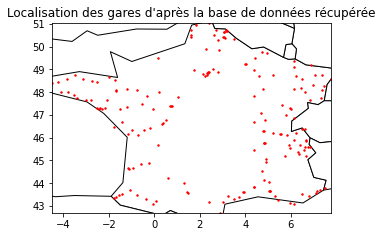

In [23]:
points = [Point(lon, lat) for ind, lat, lon in coordonnees[['Latitude', 'Longitude']].itertuples()]
enedis = geopandas.GeoDataFrame(data=dict(geometry=points))
enedis['Nom'] = coordonnees['Nom_Gare']
enedis.head()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

europe = world[(world.continent == "Europe")].copy()
europe['geometry'] = europe.geometry.intersection(Polygon([[-10,35], [50,35], [50,70], [-10, 70]]))
europe.head()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
minx, miny, maxx, maxy = enedis.total_bounds

world.plot(ax=ax, color='white', edgecolor='black')
enedis.plot(ax=ax, marker='o', color='red', markersize=2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Localisation des gares d'après la base de données récupérée");

On utilise le module Geod de pyproj pour déterminer les distances en kms. 

In [24]:
wgs84_geod = Geod(ellps ='WGS84')


def Distance(lat1,lon1,lat2,lon2):
     az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
     return dist

In [25]:
nom_gare = coordonnees['Nom_Gare'].tolist()
latitude = coordonnees['Latitude'].tolist()
longitude = coordonnees['Longitude'].tolist()

liste = [[] for i in range(len(nom_gare))]

for i in range(len(liste)) : 
    liste[i] = nom_gare[i], latitude[i], longitude[i]
    
#liste

liste contient les triplets (nom de gare, latitude, longitude) pour chaque gare. Pour chaque couple de gares contenues dans cette liste, on calcule la distance entre ces deux gares que l'on stocke dans le dictionnaire distance. 

In [26]:
distance = {}
for k in range(len(liste)) : 
    for j in range(len(liste)) : 
        distance[liste[j][0], liste[k][0]] = Distance(liste[j][1],liste[j][2], liste[k][1], liste[k][2])
        
        
gares = list(distance.keys())
gare_depart = [gares[k][0] for k in range(len(gares))]
gare_arrivee = [gares[k][1] for k in range(len(gares))]

On crée le DataFrame distance_villes qui pour une gare de départ et une gare d'arrivée donne la distance en kms entre ces deux gares. 

In [27]:
distance_villes = pandas.DataFrame({'Gare de départ' : gare_depart, 'Gare d arrivée' : gare_arrivee, 'Distance entre les villes' : list(distance.values())})
distance_villes['Distance entre les villes'] = distance_villes['Distance entre les villes']/1000

  On veut désormais combiner les deux DataFrame : bdd_sncf et distance_villes, afin d'obtenir un DataFrame final contenant : 
- le nom de la gare de départ, 
- le nom de la gare d'arrivée, 
- les tarifs correspondants,
- la distance correspondante à ce trajet. 

    Cependant, ces deux bases de données étant issues de jeux de données différents, **la syntaxe des noms de gares est différente**. Par exemple, les noms de gares dans bdd_sncf sont affichés en majuscule et sans caractères spéciaux (en particulier les tirets). On doit donc modifier la syntaxe des noms de gares contenues dans distance_villes. 

In [28]:
distance_villes['Gare de départ'] = distance_villes['Gare de départ'].str.upper()
distance_villes['Gare d arrivée'] = distance_villes['Gare d arrivée'].str.upper()
distance_villes = distance_villes.replace('\-', ' ', regex = True)
distance_villes.iloc[2502]

Gare de départ                  SÉLESTAT
Gare d arrivée               CARCASSONNE
Distance entre les villes        687.594
Name: 2502, dtype: object

Il reste néanmoins des différences entre les noms qui pointent vers des gares identiques. Pour résoudre ce problème on utilise le module Levenshtein qui permet de définir un **ratio de ressemblance entre deux chaînes de caractères**. 
On crée la fonction *ratio* qui pour une gare de départ $x$ et une gare d'arrivée $y$ de bdd_sncf, retourne l'indice de la ligne de distance_villes du trajet de $x$ à $y$ correspondant. 

In [29]:
garedepartmaj = distance_villes['Gare de départ'].tolist() 
garearrmaj = distance_villes['Gare d arrivée'].tolist()

def ratio(x,y):
    garedep = []
    ratiosd = []
    ratiosa =[]
    for gare in garedepartmaj :
        Ratio_dep = lev.ratio(gare, x) # on calcule pour chaque gare de départ de distance_villes le ratio de similitude avec x
        ratiosd.append(Ratio_dep) # la liste ratiosd stocke l'ensemble des ratios
    ratiomaxd = max(ratiosd) #on prend le max de ces ratios
    
    for i in range (len(ratiosd)):
        if ratiosd[i] == ratiomaxd:
            garedep.append(i) # on stocke dans garedep les indices des gares de départ pour lesquelles le ratio est maximal
    
    for index in garedep : 
        Ratio_arr = lev.ratio(garearrmaj[index], y) #on regarde les ratios de similitude avec la gare d'arrivée pour les gares dans garedep 
        ratiosa.append(Ratio_arr)
    
    ratiomaxa=max(ratiosa)
    for i in range (len(ratiosa)):
        if ratiosa[i] == ratiomaxa:
            return(garedep[i]) #on retourne l'indice de la ligne de distances_villes pour laquelle la gare de départ et la gare 
        #d'arrivée ont le plus grand ratio de similitude avec les gares x et y. 


In [30]:
distancegares=[]
for i in range(len(liste_gare_départ)):
    départ =liste_gare_départ[i]
    arrivée = liste_gare_arrivée[i]
    distancegares.append(distance_villes['Distance entre les villes'][ratio(départ,arrivée)])

print(distancegares) 
# distancegares contient l'ensemble des distances pour les trajets de bdd_sncf. 


[763.4494232135221, 862.3306999056759, 869.2340235577246, 728.9280520171588, 720.1620277648304, 692.9771206596267, 185.32250434949844, 418.95177403756867, 192.96627229798273, 450.243970870064, 436.0223865378026, 447.0127476523231, 393.03323572136685, 768.3214022095215, 395.4904053563777, 434.8170876252371, 522.7982889481061, 182.86916621409156, 175.78531973037073, 470.5318044481111, 470.2017997005322, 477.6755327849721, 483.16254747414354, 260.07798985513836, 415.4917785867372, 411.21987278130746, 454.68920941717835, 164.90503463342364, 615.3878469540766, 676.8821996608219, 358.72752125028256, 237.50749785441747, 632.2640194285419, 244.35749203465568, 579.6105086465208, 644.7465341936958, 367.81634632154027, 665.2470229143048, 204.13937784998478, 721.895242480806, 801.6359821745868, 405.6871376693689, 348.64900268396866, 393.03323572136685, 18.54669675447768, 21.29894225297276, 26.86424645169764, 40.50966865415426, 51.3710849549716, 45.114231036522725, 519.7045201297943, 50.07621746561

On ajoute finalement la colonne distance à la DataFrame bdd_sncf. 

In [31]:
bdd_sncf['Distance du trajet'] = distancegares
bdd_sncf
#len(distancegareskm)

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,NIMES,LILLE EUROPE,30.0,144.0,184.0,763.449423
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0,862.330700
2,LANDRY,QUIMPER,30.0,147.0,190.0,869.234024
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0,728.928052
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0,720.162028
...,...,...,...,...,...,...
4157,PLOUARET TREGOR,PARIS MONTPARNASSE 1 ET 2,20.0,99.0,138.0,310.594709
4158,DOL DE BRETAGNE,PARIS MONTPARNASSE 1 ET 2,20.0,95.0,138.0,300.186787
4159,MARNE LA VALLEE CHESSY,MORLAIX,20.0,99.0,138.0,487.541717
4160,QUIMPERLE,MARNE LA VALLEE CHESSY,20.0,103.0,147.0,481.344754


# **2. Visualisation**

Nous rappelons que :
- *bdd_1* donne pour chaque vol, son prix moyen aller-retour;
- *bdd_2* donne pour chaque vol, son prix et le mois du vol;
- *bdd_3* donne pour chaque vol, son prix et le délais entre la réservation et le vol;
- *bdd_sncf* donne pour chaque trajet de train, le prix en première et seconde classes ainsi que la distance du trajet en kms.

Nous voulons regarder s'il existe une **corrélation entre le prix des billets d'avion et les variables suivantes** : 
- le prix des billets de train,
- la distance du trajet. 
- le mois du vol,
- le délais entre la réservation et le vol.

### **Corrélation avec le prix des billets de train**

On cherche d'une part à fusionner les bases de données *bdd_sncf* et *bdd_1* afin d'obtenir pour chaque trajet, le prix moyen du billet d'avion et le prix moyen du billet de train. 


Cependant, on remarque que les noms de villes qui qualifient les départs et les arrivées sont différents selon la base de données (par exemple, *bdd_sncf* indique généralement le nom de la gare, et non le nom de la ville). 

In [32]:
bdd_sncf.head(5)

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,NIMES,LILLE EUROPE,30.0,144.0,184.0,763.449423
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0,862.330700
2,LANDRY,QUIMPER,30.0,147.0,190.0,869.234024
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0,728.928052
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0,720.162028


In [33]:
bdd_1.head(5)

,Départ,Arrivée,Prix
0,Paris,Strasbourg,247
1,Nantes,Strasbourg,170
2,Marseille,Strasbourg,208
3,Bordeaux,Strasbourg,225
4,Bruxelles,Strasbourg,205


In [34]:
bdd_1['Départ'].unique()
bdd_1['Arrivée'].unique()

array(['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest',
       'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges',
       'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers',
       'Marseille', 'Nice', 'Lyon', 'Paris'], dtype=object)

On voit que dans la base de données *bdd_1*, il y a un faible nombre de destinations et de départs. On peut donc changer à la main la syntaxe des départs et des arrivées dans la base de données *bdd_sncf* de façon à ce qu'elle soit identique à celle de *bdd_1*. Pour certaines grandes villes telles que Lyon et Paris comportant plusieurs gares, il ne faudra pas oublier de modifier le nom des toute les gares. 

Puis, on conserve seulement les lignes dont la ville de départ et d'arrivée coïncident avec celles de *bdd_1*. 

In [35]:
bdd_sncf['Gare de départ'].loc[(bdd_sncf['Gare de départ'] == 'PARIS MONTPARNASSE 1 ET 2') | (bdd_sncf['Gare de départ'] == 'PARIS AUSTERLITZ') | (bdd_sncf['Gare de départ'] == 'MASSY TGV') | (bdd_sncf['Gare de départ'] == 'MARNE LA VALLEE CHESSY') | (bdd_sncf['Gare de départ'] == 'PARIS NORD') | (bdd_sncf['Gare de départ'] == 'PARIS GARE DE LYON') |(bdd_sncf['Gare de départ'] == 'AEROPORT CDG 2 TGV ROISSY') | (bdd_sncf['Gare de départ'] =='MANTES LA J. TGV')] = 'Paris'
bdd_sncf['Gare d arrivée'].loc[(bdd_sncf['Gare d arrivée'] == 'PARIS MONTPARNASSE 1 ET 2') | (bdd_sncf['Gare d arrivée'] == 'PARIS AUSTERLITZ') | (bdd_sncf['Gare d arrivée'] == 'MASSY TGV') | (bdd_sncf['Gare d arrivée'] == 'MARNE LA VALLEE CHESSY') | (bdd_sncf['Gare d arrivée'] == 'PARIS NORD') | (bdd_sncf['Gare d arrivée'] == 'PARIS GARE DE LYON') |(bdd_sncf['Gare d arrivée'] == 'AEROPORT CDG 2 TGV ROISSY') | (bdd_sncf['Gare d arrivée'] =='MANTES LA J. TGV') ] = 'Paris'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'NANTES'] = 'Nantes'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'NANTES'] = 'Nantes'


bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'MARSEILLE ST CHARLES'] = 'Marseille'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'MARSEILLE ST CHARLES'] = 'Marseille'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'BORDEAUX ST JEAN'] = 'Bordeaux'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'BORDEAUX ST JEAN'] = 'Bordeaux'


bdd_sncf['Gare de départ'].loc[(bdd_sncf['Gare de départ'] == 'LYON PART DIEU') | (bdd_sncf['Gare de départ'] == 'LYON ST EXUPERY') | (bdd_sncf['Gare de départ'] == 'LYON PERRACHE')] = 'Lyon'
bdd_sncf['Gare d arrivée'].loc[(bdd_sncf['Gare d arrivée'] == 'LYON PART DIEU') | (bdd_sncf['Gare d arrivée'] == 'LYON ST EXUPERY') | (bdd_sncf['Gare d arrivée'] == 'LYON PERRACHE')] = 'Lyon'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'TOULOUSE MATABIAU'] = 'Toulouse'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'TOULOUSE MATABIAU'] = 'Toulouse'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'NICE VILLE' ] = 'Nice'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'NICE VILLE' ] = 'Nice'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'STRASBOURG'] = 'Strasbourg'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'STRASBOURG'] = 'Strasbourg'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'BREST' ] = 'Brest'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'BREST' ] = 'Brest'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'MONTPELLIER' ] = 'Montpellier'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'MONTPELLIER' ] = 'Montpellier'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'LIMOGES BENEDICTINS'] = 'Limoges'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'LIMOGES BENEDICTINS'] = 'Limoges'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'METZ VILLE'] = 'Metz'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'METZ VILLE'] = 'Metz'

bdd_sncf['Gare de départ'].loc[(bdd_sncf['Gare de départ'] == 'LILLE FLANDRES') | (bdd_sncf['Gare de départ'] == 'LILLE EUROPE') ] = 'Lille'
bdd_sncf['Gare d arrivée'].loc[(bdd_sncf['Gare d arrivée'] == 'LILLE FLANDRES') | (bdd_sncf['Gare d arrivée'] == 'LILLE EUROPE') ] = 'Lille'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] == 'CAEN' ] = 'Caen'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] == 'CAEN' ] = 'Caen'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] ==  ' POITIERS'] = 'Poitiers'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] ==  ' POITIERS'] = 'Poitiers'

bdd_sncf['Gare de départ'].loc[bdd_sncf['Gare de départ'] ==  'RENNES'] = 'Rennes'
bdd_sncf['Gare d arrivée'].loc[bdd_sncf['Gare d arrivée'] ==  'RENNES'] = 'Rennes'

liste_villes = ['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest',
       'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges',
       'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers',
       'Marseille', 'Nice', 'Lyon', 'Paris','Bordeaux'] ##contient tous les destinations et villes de départ de bdd_1

indexlist=[]
for villedep in liste_villes:
    for villearr in liste_villes:
        inter = bdd_sncf[(bdd_sncf['Gare de départ'] == villedep)]
        listelement = inter[inter['Gare d arrivée']==villearr].index.values.astype(int)
        if listelement.size!=0:
            indexlist.append(listelement[0])  ## listelement stocke tous les indices des lignes de bdd_sncf dont les départs 
            #et arrivées sont dans bdd_1. 

bdd_sncf = bdd_sncf[bdd_sncf.index.isin(indexlist)]
bdd_sncf

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
7,Limoges,Paris,25.0,88.0,111.0,418.951774
85,Paris,Lyon,25.0,97.0,133.0,382.703675
86,Metz,Lyon,20.0,88.0,112.0,384.902365
103,Brest,Paris,20.0,92.0,131.0,505.076392
207,Paris,Montpellier,25.0,114.0,160.0,503.523601
...,...,...,...,...,...,...
3454,Nantes,Paris,20.0,85.0,122.0,336.159718
3754,Marseille,Rennes,30.0,142.0,180.0,773.008188
3871,Strasbourg,Marseille,20.0,124.0,161.0,616.720319
4120,Strasbourg,Lille,25.0,132.0,152.0,410.073399


On effectue la fusion de la nouvelle base obtenue *bdd_sncf* et *bdd_1* de façon à pouvoir comparer les prix des billets de train et ceux d'avion pour un même trajet. 


***bdd_corr_1* contient alors pour chaque trajet aller-retour, le prix du billet de train (dans la colonne "Prix moyen", qui correspond à la moyenne des tarifs de première et de seconde classe) et celui du billet d'avion (dans la colonne "Prix", et qui correspond également à un prix moyen).**

In [36]:
bdd_corr = pandas.merge(bdd_1, bdd_sncf, left_on = [bdd_1['Départ'],bdd_1['Arrivée']], right_on = [bdd_sncf['Gare de départ'], bdd_sncf['Gare d arrivée']], how = 'inner')
bdd_corr = bdd_corr.drop(['Gare de départ', 'Gare d arrivée', 'Prix d appel seconde', 'key_0', 'key_1'], axis=1)
bdd_corr['Prix moyen'] = bdd_corr['Plein tarif loisir seconde'] + bdd_corr['Tarif premiere classe']
bdd_corr_1 =  bdd_corr.drop(['Distance du trajet', 'Plein tarif loisir seconde', 'Tarif premiere classe', 'Départ', 'Arrivée'], axis = 1)
bdd_corr_1

,Prix,Prix moyen
0,154,193.0
1,241,73.0
2,163,322.0
3,160,251.0
4,178,274.0
5,257,178.0
6,245,151.0
7,132,251.0
8,145,169.0
9,289,103.0


On peut regarder la répartition des prix pour le train et l'avion à l'aide d'un histogramme afin de voir s'il n'y a pas de valeurs aberrantes. 

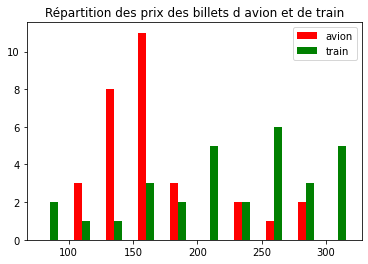

In [37]:
plt.hist([bdd_corr_1['Prix'], bdd_corr_1['Prix moyen']], rwidth = 0.5, color = ['red', 'green'], label = ['avion', 'train'])
plt.title('Répartition des prix des billets d avion et de train')
plt.legend()

Nous souhaitons regarder s'il existe une corrélation entre ces deux variables, qui sont des variables quantitatives. 

Regardons d'une part s'il existe **une corrélation linéaire entre les deux variables obtenues dans *bdd_corr_1* avec le test de Pearson :** 

In [38]:
stats.pearsonr(bdd_corr_1['Prix'], bdd_corr_1['Prix moyen'])

(-0.6692479117706398, 5.258153867108818e-05)

On voit que le coefficient de Pearson est égal en valeur absolue à $0.65$ avec une p-value de $0.0001$. Ainsi, si on fixe un seuil de significativité à $1$%, on peut donc affirmer que le coefficient de corrélation est significatif. Le coefficient de Pearson en valeur absolue est relativement proche de 1, donc on peut dire qu'il existe une relation linéaire modérée entre le prix des billets de train et celui des billets d'avion. 

On réalise une régression avec le module seaborn : 

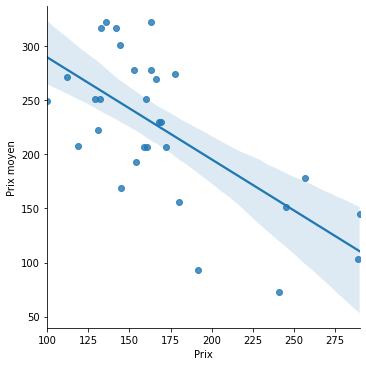

In [39]:
## Représentation graphique
sn.lmplot(x = 'Prix', y = 'Prix moyen', data = bdd_corr_1)

On remarque que de nombreux points sont espacés de la droite de régression linéaire simple; cette régression est donc de qualité médiocre.

Pour plus de précision sur la régression, on utilise le module statsmodels :

In [40]:
X = sm.add_constant(bdd_corr_1['Prix'])
model = sm.OLS(bdd_corr_1['Prix moyen'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Prix moyen   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     22.71
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           5.26e-05
Time:                        14:27:57   Log-Likelihood:                -159.95
No. Observations:                  30   AIC:                             323.9
Df Residuals:                      28   BIC:                             326.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        383.8801     34.826     11.023      0.0

D'après les résultats obtenus, on constate que $R²$ = $0.421$ donc la modélisation par la droite des moindres carrés explique 42 % de la variation totale, ce qui constitue un résultat moyen.  

On peut regarder désormais s'il existe un lien non linéaire entre les deux variables étudiées, en regardant par exemple le coefficient de Spearman. 

In [41]:
stats.spearmanr(bdd_corr_1['Prix'], bdd_corr_1['Prix moyen'])

SpearmanrResult(correlation=-0.56678220115841, pvalue=0.0010924122681565504)

Le coefficient de corrélation de Spearman est significatif au seuil de $5$% (p-value faible, égale à $0.0029$), il est égal en valeur absolue à $0.52$ donc la dépendance entre les deux variables est modérée. Par ailleurs, ce coefficient est négatif ce qui indique que **plus les billets de train sont chers, plus les prix des billets d'avion sont faibles.**

### **Corrélation avec la distance**

**La base de données *bdd_corr_2* contient pour chaque trajet, le prix et la distance du trajet associée.**

In [42]:
bdd_corr_2 = bdd_corr.drop(['Prix moyen'], axis = 1)
bdd_corr_2.head(5)

,Départ,Arrivée,Prix,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,Paris,Rennes,154,80.0,113.0,329.462708
1,Nantes,Rennes,241,30.0,43.0,95.330640
2,Marseille,Rennes,163,142.0,180.0,773.008188
3,Lyon,Rennes,160,108.0,143.0,560.838254
4,Paris,Montpellier,178,114.0,160.0,503.523601


Puisqu'il s'agit de deux variables quantitatives, on peut regarder leur corrélation de la même façon que fait précédemment avec le prix des billets de train. 

In [43]:
## Test de Pearson
stats.pearsonr(bdd_corr_2['Prix'], bdd_corr_2['Distance du trajet'])

(-0.5833389831974132, 0.0007158627302965733)

Le coefficient de Pearson étant significatif (p-value faible) et égal en valeur absolue à $0.56$, on peut affirmer qu'il existe une relation linéaire entre les 2 variables modérée. 

##### **Représentation graphique avec seaborn**

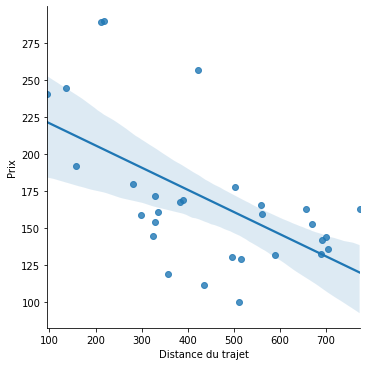

In [44]:
sn.lmplot(x = 'Distance du trajet', y = 'Prix', data = bdd_corr_2)

Contrairement avec le prix des billets de train où cette variable semble fortement corrélée avec la distance : 

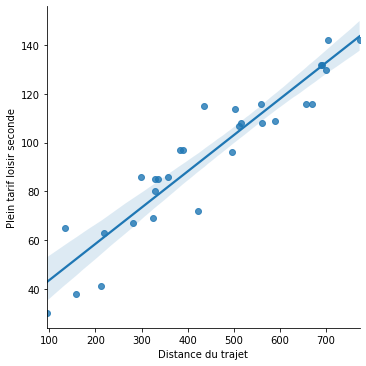

In [45]:
sn.lmplot(x = 'Distance du trajet', y = 'Plein tarif loisir seconde', data = bdd_corr_2)

##### **Utilisation du module statsmodels**

In [46]:
X = sm.add_constant(bdd_corr_2['Distance du trajet'])
model = sm.OLS(bdd_corr_1['Prix'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     14.44
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           0.000716
Time:                        14:27:58   Log-Likelihood:                -152.34
No. Observations:                  30   AIC:                             308.7
Df Residuals:                      28   BIC:                             311.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                235.9311     18

D'après les résultats obtenus, $R²$ est faible : la modélisation par la méthode des moindres carrés explique 31.7% de la variation totale, ce qui constitue une précision faible. 

On regarde le coefficient de Spearman pour déterminer une possible corrélation non linéaire :

In [47]:
stats.spearmanr(bdd_corr_2['Prix'], bdd_corr_2['Distance du trajet'])

SpearmanrResult(correlation=-0.562242744607179, pvalue=0.001221952115206841)

Le coefficient de Spearman est significatif (p-valeur faible) et est égal en valeur absolue à $0.53$ donc il est difficile d'interpréter une corrélation non linéaire entre les deux variables. 

### **Corrélation avec le mois du vol** 

Regardons dans un premier temps la répartition des prix des billets d'avion. 

Text(0.5, 1.0, 'Répartition des prix des billets d avion')

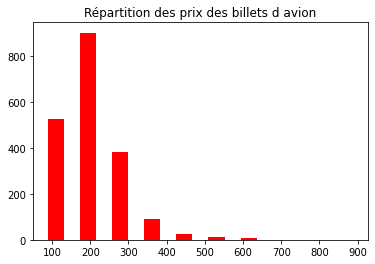

In [48]:
plt.hist(bdd_2['Prix'], rwidth = 0.5, color = 'red')
plt.title('Répartition des prix des billets d avion')

Nous pouvons constater qu'il existe **plusieurs valeurs aberrantes de prix pour les billets d'avion** : par exemple des billets de plus de $1000 €$. Déterminons les trajets pour lesquels les valeurs de prix sont aberrantes  :

In [49]:
bdd_2[bdd_2['Prix']>500]

,Départ,Arrivée,Prix,Mois
27,Marseille,Strasbourg,591,avr
513,Bruxelles,Ajaccio,602,déc
613,Bruxelles,Bastia,565,avr
621,Bruxelles,Bastia,628,déc
720,Bruxelles,Calvi,528,avr
907,Marseille,Montpellier,592,mai
918,Bordeaux,Montpellier,524,avr
966,Toulouse,Montpellier,908,juin
1000,Marseille,Limoges,509,août
1513,Paris,Poitiers,543,nov


 On constate que certains tarifs sont extrêmement élevés car pour des trop courtes distances, il n'existe pas de vol direct et donc une voire plusieurs correspondances sont proposées en remplacement. On supprime donc ces quelques valeurs aberrantes de la base de données.

In [50]:
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Nice') & (bdd_2['Arrivée'] == 'Marseille')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Bordeaux') & (bdd_2['Arrivée'] == 'Nantes')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Toulouse') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Marseille') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Bordeaux') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Nice') & (bdd_2['Arrivée'] == 'Ajaccio')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Paris') & (bdd_2['Arrivée'] == 'Strasbourg')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Toulouse') & (bdd_2['Arrivée'] == 'Bordeaux')].index, inplace = True)
bdd_2

,Départ,Arrivée,Prix,Mois
12,Nantes,Strasbourg,210,jan
13,Nantes,Strasbourg,157,fév
14,Nantes,Strasbourg,165,mar
15,Nantes,Strasbourg,171,avr
16,Nantes,Strasbourg,162,mai
...,...,...,...,...
1944,Nice,Paris,150,août
1945,Nice,Paris,124,sep
1946,Nice,Paris,124,oct
1947,Nice,Paris,121,nov


**bdd_corr_3 contient pour chaque vol, le prix du billet aller retour selon le mois correspondant.**

In [51]:
bdd_corr_3 = bdd_2.copy()
bdd_corr_3 = bdd_corr_3.pivot_table(index = ['Départ', 'Arrivée'], columns = 'Mois', values = 'Prix')
bdd_corr_3 = bdd_corr_3.reset_index()
bdd_corr_3 = bdd_corr_3.drop(['Départ', 'Arrivée'], axis = 1)
bdd_corr_3

Mois,août,avr,déc,fév,jan,juil,juin,mai,mar,nov,oct,sep
0,248.0,256.0,231.0,209.0,208.0,264.0,255.0,252.0,313.0,217.0,170.0,164.0
1,336.0,356.0,238.0,200.0,192.0,318.0,345.0,307.0,312.0,224.0,207.0,189.0
2,158.0,216.0,176.0,172.0,139.0,165.0,187.0,191.0,179.0,147.0,153.0,157.0
3,253.0,218.0,238.0,241.0,NaN,220.0,224.0,200.0,213.0,209.0,199.0,169.0
4,292.0,266.0,234.0,171.0,165.0,271.0,261.0,238.0,189.0,166.0,215.0,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,156.0,129.0,118.0,124.0,97.0,153.0,147.0,124.0,179.0,115.0,116.0,140.0
155,140.0,112.0,114.0,109.0,108.0,148.0,149.0,124.0,111.0,109.0,120.0,116.0
156,500.0,278.0,NaN,NaN,NaN,301.0,245.0,257.0,336.0,NaN,NaN,NaN
157,185.0,137.0,198.0,166.0,120.0,162.0,136.0,141.0,292.0,174.0,157.0,124.0


On voit qu'il y a plusieurs valeurs manquantes. Nous pouvons dans un premier temps les remplacer par la médiane du prix du billet du trajet correspondant. 

In [52]:
bdd_corr_3_new = bdd_corr_3.T
for i in range(1,159) : 
    median = bdd_corr_3_new[i].median()
    bdd_corr_3_new[i].fillna(median, inplace=True)  
bdd_corr_3 = bdd_corr_3_new.T
bdd_corr_3.head(5)

Mois,août,avr,déc,fév,jan,juil,juin,mai,mar,nov,oct,sep
0,248.0,256.0,231.0,209.0,208.0,264.0,255.0,252.0,313.0,217.0,170.0,164.0
1,336.0,356.0,238.0,200.0,192.0,318.0,345.0,307.0,312.0,224.0,207.0,189.0
2,158.0,216.0,176.0,172.0,139.0,165.0,187.0,191.0,179.0,147.0,153.0,157.0
3,253.0,218.0,238.0,241.0,218.0,220.0,224.0,200.0,213.0,209.0,199.0,169.0
4,292.0,266.0,234.0,171.0,165.0,271.0,261.0,238.0,189.0,166.0,215.0,214.0


On regarde tout d'abord l'allure de l'évolution des prix selon les mois pour plusieurs trajets aléatoires. 

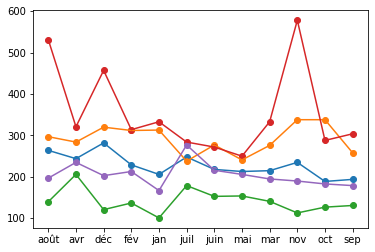

In [53]:
bdd_corr_3_test = bdd_corr_3.sample(10)
bdd_corr_3_test = bdd_corr_3_test.reset_index()
bdd_corr_3_test = bdd_corr_3_test.drop(['index'], axis = 1)
x = bdd_corr_3_test.columns
for i in range(5) :
    plt.scatter(x,bdd_corr_3_test.loc[i])
    plt.plot(x,bdd_corr_3_test.loc[i], linestyle= 'solid')


En observant les courbes pour plusieurs échantillons de trajets, il semble difficile de déterminer une évolution similaire entre elles.

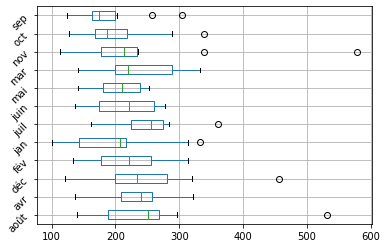

In [54]:
boxplot = bdd_corr_3_test.boxplot(column = bdd_corr_3_test.columns.tolist(), fontsize = 10, rot = 45, vert = 0)
boxplot

D'après les boîtes de Tukey précédentes on constate que : 
- les écarts interquartiles sont sensiblement identiques pour les mois de janvier, mars, main, juin, novembre d'une part, et avril, juillet, août, septembre, octobre d'autre part, avec un écart interquartile nettement plus faible. Cela signifie que les prix sont bien plus hétérogènes pour le premier groupe que pour le second groupe. 
- l'étendue des boîtes pour les mois de mai et juin sont extrêmement importantes; les prix sont donc particulièrement hétérogènes pour ces deux mois; 
- il existe quelques valeurs aberrantes qui peuvent fausser les résultats obtenus. 

### **Corrélation avec le délais de réservation**

In [55]:
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Nice') & (bdd_3['Arrivée'] == 'Marseille')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Bordeaux') & (bdd_3['Arrivée'] == 'Nantes')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Toulouse') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Marseille') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Bordeaux') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Nice') & (bdd_3['Arrivée'] == 'Ajaccio')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Paris') & (bdd_3['Arrivée'] == 'Strasbourg')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Toulouse') & (bdd_3['Arrivée'] == 'Bordeaux')].index, inplace = True)
bdd_3

,Départ,Arrivée,Prix,Temps entre la réservation et le vol
12,Nantes,Strasbourg,223,0 à 1 mois
13,Nantes,Strasbourg,171,1 à 2 mois
14,Nantes,Strasbourg,133,2 à 3 mois
15,Nantes,Strasbourg,159,3 à 4 mois
16,Nantes,Strasbourg,163,4 à 5 mois
...,...,...,...,...
1621,Nice,Paris,119,7 à 8 mois
1622,Nice,Paris,124,8 à 9 mois
1623,Nice,Paris,149,9 à 10 mois
1624,Nice,Paris,127,10 à 11 mois


**bdd_corr_4 contient pour chaque vol, le prix aller retour pour chaque délais de réservation**. 

In [56]:
bdd_corr_4 = bdd_3.copy()
bdd_corr_4 = bdd_corr_4.pivot_table(index = ['Départ', 'Arrivée'], columns = 'Temps entre la réservation et le vol', values = 'Prix')
bdd_corr_4 = bdd_corr_4.reset_index()
bdd_corr_4 = bdd_corr_4.drop(['Départ', 'Arrivée'], axis = 1)
bdd_corr_4
bdd_corr_4

Temps entre la réservation et le vol,0 à 1 mois,1 à 2 mois,10 à 11 mois,11 à 12 mois,2 à 3 mois,3 à 4 mois,4 à 5 mois,5 à 6 mois,6 à 7 mois,7 à 8 mois,8 à 9 mois,9 à 10 mois
0,174.0,147.0,194.0,194.0,145.0,226.0,365.0,270.0,335.0,299.0,386.0,237.0
1,218.0,188.0,264.0,264.0,184.0,289.0,330.0,416.0,388.0,544.0,351.0,278.0
2,190.0,175.0,116.0,117.0,167.0,154.0,160.0,159.0,147.0,152.0,121.0,112.0
3,245.0,200.0,NaN,NaN,184.0,189.0,191.0,NaN,NaN,NaN,NaN,NaN
4,269.0,226.0,NaN,NaN,209.0,226.0,234.0,232.0,244.0,302.0,326.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
154,150.0,132.0,283.0,200.0,115.0,152.0,117.0,120.0,124.0,135.0,128.0,139.0
155,123.0,110.0,127.0,142.0,107.0,129.0,132.0,125.0,177.0,117.0,160.0,194.0
156,338.0,354.0,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,195.0,141.0,NaN,NaN,142.0,172.0,159.0,148.0,138.0,145.0,261.0,NaN


On voit qu'il y a plusieurs valeurs manquantes. Nous pouvons dans un premier temps les remplacer par la médiane du prix du billet du trajet correspondant. 

In [57]:
bdd_corr_4_new = bdd_corr_4.T
for i in range(1,159) : 
    median = bdd_corr_4_new[i].median()
    bdd_corr_4_new[i].fillna(median, inplace=True)  
bdd_corr_4 = bdd_corr_4_new.T
bdd_corr_4.head(5)

Temps entre la réservation et le vol,0 à 1 mois,1 à 2 mois,10 à 11 mois,11 à 12 mois,2 à 3 mois,3 à 4 mois,4 à 5 mois,5 à 6 mois,6 à 7 mois,7 à 8 mois,8 à 9 mois,9 à 10 mois
0,174.0,147.0,194.0,194.0,145.0,226.0,365.0,270.0,335.0,299.0,386.0,237.0
1,218.0,188.0,264.0,264.0,184.0,289.0,330.0,416.0,388.0,544.0,351.0,278.0
2,190.0,175.0,116.0,117.0,167.0,154.0,160.0,159.0,147.0,152.0,121.0,112.0
3,245.0,200.0,191.0,191.0,184.0,189.0,191.0,191.0,191.0,191.0,191.0,191.0
4,269.0,226.0,234.0,234.0,209.0,226.0,234.0,232.0,244.0,302.0,326.0,234.0


Déterminons tout d'abord l'allure de l'évolution des prix selon le délais de réservation. 

In [58]:
bdd_corr_4_test = bdd_corr_4.sample(10)
bdd_corr_4_test = bdd_corr_4_test.reset_index()
bdd_corr_4_test = bdd_corr_4_test.drop(['index'], axis = 1)

x = bdd_corr_4_test.columns ## on réordonne x, ie on place les éléments 10 à 11 mois et 11 à 12 mois en fin de liste
x = x.tolist()
a = x[2]
b = x[3]
del x[2:4]
x.append(a)
x.append(b)


Text(0.5, 1.0, 'Evolution du prix du billet selon le délais de réservation pour dix trajets')

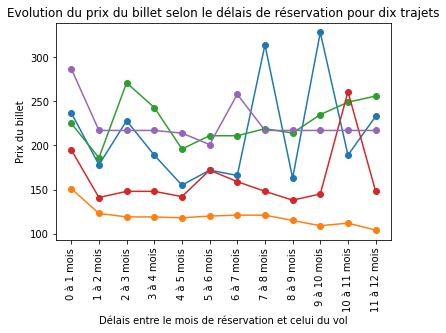

In [59]:
for i in range(5) :
    plt.scatter(x,bdd_corr_4_test.loc[i])
    plt.plot(x,bdd_corr_4_test.loc[i], linestyle= 'solid')
    
plt.xticks(rotation = 90)
plt.xlabel('Délais entre le mois de réservation et celui du vol')
plt.ylabel('Prix du billet')
plt.title('Evolution du prix du billet selon le délais de réservation pour dix trajets')


Etant donné que les courbes suivent une trajectoire plus ou moins similaire, il semblerait qu'il existe une corrélation entre les deux variables étudiées. 

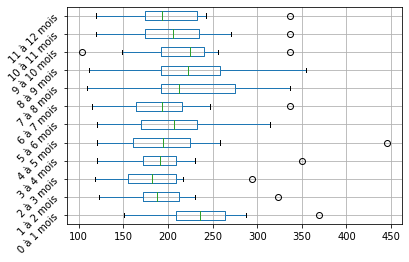

In [60]:
boxplot = bdd_corr_4_test.boxplot(column = x, fontsize = 10, rot = 45, vert = 0)
boxplot

Si on remplace désormais les valeurs manquantes par la moyenne des prix du billet du trajet correspondant, et que l'on opère de même : 

In [61]:
bdd_corr_4_new = bdd_corr_4.T
for i in range(1,159) : 
    mean = bdd_corr_4_new[i].mean()
    bdd_corr_4_new[i].fillna(mean, inplace=True)  
bdd_corr_4 = bdd_corr_4_new.T
bdd_corr_4.head(5)

bdd_corr_4_test_1 = bdd_corr_4.sample(10)
bdd_corr_4_test_1 = bdd_corr_4_test_1.reset_index()
bdd_corr_4_test_1 = bdd_corr_4_test_1.drop(['index'], axis = 1)

x = bdd_corr_4_test_1.columns ## on réordonne x, ie on place les éléments 10 à 11 mois et 11 à 12 mois en fin de liste
x = x.tolist()
a = x[2]
b = x[3]
del x[2:4]
x.append(a)
x.append(b)

Text(0.5, 1.0, 'Evolution du prix du billet selon le délais de réservation pour dix trajets')

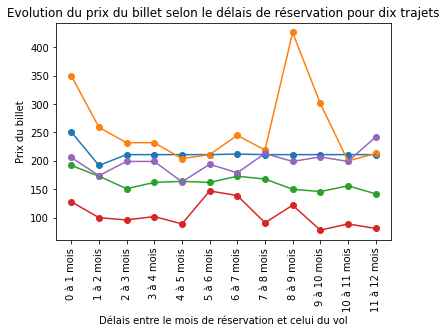

In [62]:
for i in range(5) :
    plt.scatter(x,bdd_corr_4_test_1.loc[i])
    plt.plot(x,bdd_corr_4_test_1.loc[i], linestyle= 'solid')
    
plt.xticks(rotation = 90)
plt.xlabel('Délais entre le mois de réservation et celui du vol')
plt.ylabel('Prix du billet')
plt.title('Evolution du prix du billet selon le délais de réservation pour dix trajets')


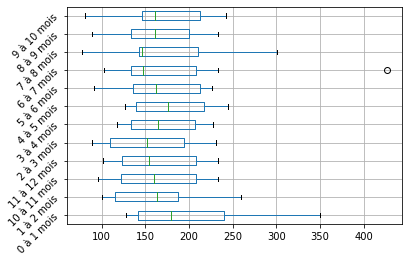

In [63]:
boxplot = bdd_corr_4_test_1.boxplot(column = bdd_corr_4_test_1.columns.tolist(), fontsize = 10, rot = 45, vert = 0)
boxplot

### **Conclusion** 

D'après les résultats précédents, on peut conclure que :
- il existe une relation linéaire modérée entre les prix des billets d'avion et ceux de train. En particulier, **les deux variables sont négativement corrélées**,
- il n'existe pas vraiment de relation entre les prix des billets d'avion et la distance du trajet,
- relation avec les délais de réservation et les mois à définir? 


# **3. Modélisation**

In [67]:
df1 = bdd_3.copy()
df2 = bdd_2.copy()

In [70]:
df1.columns = ['Départ', 'Arrivée', 'Prix', 'Temps']
df1

,Départ,Arrivée,Prix,Temps
12,Nantes,Strasbourg,223,0 à 1 mois
13,Nantes,Strasbourg,171,1 à 2 mois
14,Nantes,Strasbourg,133,2 à 3 mois
15,Nantes,Strasbourg,159,3 à 4 mois
16,Nantes,Strasbourg,163,4 à 5 mois
...,...,...,...,...
1621,Nice,Paris,119,7 à 8 mois
1622,Nice,Paris,124,8 à 9 mois
1623,Nice,Paris,149,9 à 10 mois
1624,Nice,Paris,127,10 à 11 mois


On transforme le temps jusqu'à l'achat du billet en un entier représentant le nombre de mois avant le départ. Celà permettra d'éviter un encodage catégoriel de cette variable qui peut être vue comme une variable discrète.

In [101]:
bdd_sncf.dtypes.value_counts(), df1.dtypes.value_counts()

(object     3
 float64    3
 dtype: int64, object    2
 int64     2
 dtype: int64)

In [71]:
df1.Temps = df1.Temps.apply(lambda x: [int(s) for s in x.split(' ') if s.isdigit()][1])

"On reprend l'étape de fusion des bases de données. Dans notre modélisation, on va conserver plus de variables. On a en effet vu dans la partie statistiques descriptives que des variables comme le prix des billets d'avion et le prix moyen des billets de train, ou encore le temps avant le départ et le prix du billet d'avion. **On va donc conserver ces variables**"

In [72]:
bdd_sncf

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
7,Limoges,Paris,25.0,88.0,111.0,418.951774
85,Paris,Lyon,25.0,97.0,133.0,382.703675
86,Metz,Lyon,20.0,88.0,112.0,384.902365
103,Brest,Paris,20.0,92.0,131.0,505.076392
207,Paris,Montpellier,25.0,114.0,160.0,503.523601
...,...,...,...,...,...,...
3454,Nantes,Paris,20.0,85.0,122.0,336.159718
3754,Marseille,Rennes,30.0,142.0,180.0,773.008188
3871,Strasbourg,Marseille,20.0,124.0,161.0,616.720319
4120,Strasbourg,Lille,25.0,132.0,152.0,410.073399


In [89]:
bdd_corr11 = pandas.merge(df1, bdd_sncf, left_on = [df1['Départ'],df1['Arrivée']], right_on = [bdd_sncf['Gare de départ'], bdd_sncf['Gare d arrivée']], how = 'inner')
bdd_corr11 = bdd_corr11.drop(['Prix d appel seconde', 'key_0', 'key_1'], axis=1)
bdd_corr11['Prix moyen'] =(bdd_corr11['Plein tarif loisir seconde'] + bdd_corr11['Tarif premiere classe'])
bdd_corr_11 =  bdd_corr11.drop(['Plein tarif loisir seconde', 'Tarif premiere classe', 'Départ', 'Arrivée'], axis = 1)
bdd_corr_11.head(5)

,Prix,Temps,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,172,1,Paris,Rennes,329.462708,193.0
1,147,2,Paris,Rennes,329.462708,193.0
2,140,3,Paris,Rennes,329.462708,193.0
3,139,4,Paris,Rennes,329.462708,193.0
4,151,5,Paris,Rennes,329.462708,193.0


In [95]:
bdd_corr21 = pandas.merge(df2, bdd_sncf, left_on = [df2['Départ'],df2['Arrivée']], right_on = [bdd_sncf['Gare de départ'], bdd_sncf['Gare d arrivée']], how = 'inner')
bdd_corr21 = bdd_corr21.drop(['Prix d appel seconde', 'key_0', 'key_1'], axis=1)
bdd_corr21['Prix moyen'] =(bdd_corr21['Plein tarif loisir seconde'] + bdd_corr21['Tarif premiere classe'])
bdd_corr_21 =  bdd_corr21.drop(['Plein tarif loisir seconde', 'Tarif premiere classe'], axis = 1)
bdd_corr_21.head(5)

,Départ,Arrivée,Prix,Mois,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,Paris,Rennes,133,jan,Paris,Rennes,329.462708,193.0
1,Paris,Rennes,136,fév,Paris,Rennes,329.462708,193.0
2,Paris,Rennes,293,mar,Paris,Rennes,329.462708,193.0
3,Paris,Rennes,134,avr,Paris,Rennes,329.462708,193.0
4,Paris,Rennes,130,mai,Paris,Rennes,329.462708,193.0


In [99]:
bdd_corr_21.shape

(343, 8)

In [100]:
bdd_corr_11.shape

(318, 6)

Les données avec lesquelles on va travailler sont beaucoup moins nombreuses

**On affiche ci dessous les colonnes de chaque dataset, pour comprendre ce qu'il représente**

In [96]:
bdd_corr_11.columns, bdd_corr_21.columns

(Index(['Prix', 'Temps', 'Gare de départ', 'Gare d arrivée',
        'Distance du trajet', 'Prix moyen'],
       dtype='object'),
 Index(['Départ', 'Arrivée', 'Prix', 'Mois', 'Gare de départ', 'Gare d arrivée',
        'Distance du trajet', 'Prix moyen'],
       dtype='object'))

$\to$ Gare de départ / départ et gare d'arrivée /arrivée sont les mêmes variables.

$\to$ La colonne qui change entre les deux datasets est la colonne 'Temps' qui représente le délais entre l'achat du billet et le départ, et la colonne 'Mois', qui représente le mois du vol. Si on voulait fusionner les deux datasets, on perdrait énormément d'information (de lignes). En effet, les données doivent être fusionnées sur le départ, l'arrivée, et une variable de prix, pour s"assurer qu'il s'agit bien du même trajet. Ce problème vient du fait que le prix dépend de la variable Temps, et de la vraible Mois. On a des bases séparées, donc on a pas forcément des dépendances simultanées. On perdrait donc beaucoup de lignes, ce qui ne nous arrange pas pour le modèle.

In [103]:
df = bdd_corr_11.copy()
df_bis = bdd_corr_21.copy()

In [104]:
df.dtypes.value_counts()

object     2
float64    2
int64      2
dtype: int64

### **Analyse par variables**

On va beaucoup d'intéresser aux variables catégorielles, puisque nous allons devoir les encoder

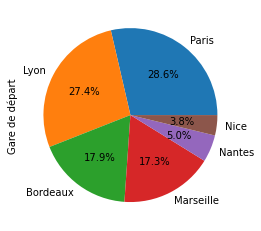

In [105]:
df['Gare de départ'].value_counts().plot.pie(autopct='%1.1f%%')

On constate que le nombre de trajets qui partent de certaines gares est plus élevé que pour d'autres gares. A priori, on ne peut pas dire si celà a une incidence sur le prix du billet d'avion. Il est à noter ici que 'Gare de départ' représente plus la ville de départ qu'une gare. C'est donc le cas aussi pour les trajets d'avion. 

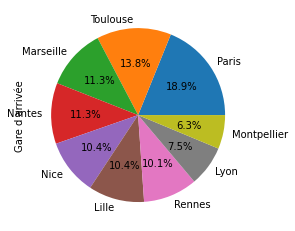

In [106]:
df['Gare d arrivée'].value_counts().plot.pie(autopct='%1.1f%%')

Les gare d'arrivées recoivent elles plus ou moins le même nombre de trajets.

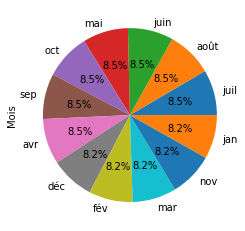

In [107]:
df_bis['Mois'].value_counts().plot.pie(autopct = '%1.1f%%')

$\to$ Pour le deuxième dataset, on constate que le nombre de vol par mois semble être le même. On ne met donc pas en évidence ici des mois avec plus de demande, donc potentiellement un prix plus élevé. C'est simplement notre échantillon qui est équiréparti entre les mois. Il sera tout de même interessant de s'intéresser au prix par mois.

### **Preprocessing**

On va utiliser un encodage OneHot pour les colonnes avec des types objets, et un RobustScaler pour faire face aux valeurs aberrantes que l'on a pu constater. On réfléchira ensuite à la pertinence de l'imputation de ces valeurs au datasets. On pourra également réfléchir à la métrique utilisée pour parvenir à nos fins.

**Justification du OneHotEncoding**: ici, on fait face à un grand nombre de possibilité d'issue pour les variables que l'on encode, qui seront 'Gare de départ' et 'Gare d arrivée'. De plus, il n'existe pas de relation séquentielle entre celles-ci. De plus, si on encodait les noms des gares par [1,2,3,4,5] par exemple, on aurait le 1 et le 2 très proches dans l'encodage, mais pour autant pas proche du tout dans la réalité, si par exemple celà correspond à Paris et Strasbourg, par la géographie d'une part, mais aussi de prix, de nombre de départs, etc. Un encodage OneHot, qui attribue un vecteur comprenant une unité 1 à la coordonnée i pour coder l'issue i de la variable, donne une vraie distance entre les gares.

**Justification du RobustScaler :** Ici, on applique la formule $ \dfrac{\text{valeur} - \text{médiane}}{\text{inter-quartile}} $. La médiane est moins sensible que la moyenne aux outliers, là où dans certains normalisateurs, on a la moyenne. On a donc une première approche ici de prise en compte des valeurs aberrantes. On peut s'en convaincre sur le graphe suivant.

### **Premier dataset**
(Contient la variable $\textit{Temps}$)

In [109]:
dfm = df.copy()
dfm.Prix = dfm.Prix.astype('float')
dfm.Temps = dfm.Temps.astype('float')
#On passe le prix et le temps en flottants pour pouvoir les passer dans le scaler.

In [110]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

ohe = OneHotEncoder(sparse = False) #On demande un array et une sparse matrix pour ne pas avoir de problèmes avec les autres
                                    #fonctions de scikit-learn.
rob = RobustScaler()

In [112]:
# Normalisation des variables flottantes

for flo in dfm.select_dtypes('float'):
    dfm[flo] = rob.fit_transform(numpy.array(dfm[flo]).reshape(-1,1))

In [113]:
dfm

,Prix,Temps,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,0.393162,-0.833333,Paris,Rennes,-0.509805,-0.788732
1,-0.034188,-0.666667,Paris,Rennes,-0.509805,-0.788732
2,-0.153846,-0.500000,Paris,Rennes,-0.509805,-0.788732
3,-0.170940,-0.333333,Paris,Rennes,-0.509805,-0.788732
4,0.034188,-0.166667,Paris,Rennes,-0.509805,-0.788732
...,...,...,...,...,...,...
313,-0.512821,0.333333,Nice,Paris,0.590782,0.957746
314,-0.427350,0.500000,Nice,Paris,0.590782,0.957746
315,0.000000,0.666667,Nice,Paris,0.590782,0.957746
316,-0.376068,0.833333,Nice,Paris,0.590782,0.957746


In [115]:
# Encodage des valeurs catégorielles


arr = ohe.fit_transform(numpy.array(dfm['Gare de départ']).reshape(-1,1))
names = ohe.categories_
names = [x + '_d'for x in names[0]] #on identifie les variables des villes avec un _départ pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = dfm.drop('Gare de départ', axis = 1)
dfm = pandas.concat([temp, arr2], axis = 1)


arr = ohe.fit_transform(numpy.array(dfm['Gare d arrivée']).reshape(-1,1))
names = ohe.categories_
names = [x + '_a'for x in names[0]]  #on identifie les variables des villes avec un _arrivée pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = dfm.drop('Gare d arrivée', axis = 1)
dfm = pandas.concat([temp, arr2], axis = 1)

In [116]:
dfm.columns, df['Gare de départ'].unique(), df['Gare d arrivée'].unique()
#On peut vérifier que l'encodage s'est bien fait

(Index(['Prix', 'Temps', 'Distance du trajet', 'Prix moyen', 'Bordeaux_d',
        'Lyon_d', 'Marseille_d', 'Nantes_d', 'Nice_d', 'Paris_d', 'Lille_a',
        'Lyon_a', 'Marseille_a', 'Montpellier_a', 'Nantes_a', 'Nice_a',
        'Paris_a', 'Rennes_a', 'Toulouse_a'],
       dtype='object'),
 array(['Paris', 'Nantes', 'Marseille', 'Lyon', 'Bordeaux', 'Nice'],
       dtype=object),
 array(['Rennes', 'Montpellier', 'Toulouse', 'Lille', 'Nantes',
        'Marseille', 'Nice', 'Lyon', 'Paris'], dtype=object))

In [117]:
dfm
#On a désormais un dataset plus grand avec toutes nos valeurs encodées

,Prix,Temps,Distance du trajet,Prix moyen,Bordeaux_d,Lyon_d,Marseille_d,Nantes_d,Nice_d,Paris_d,Lille_a,Lyon_a,Marseille_a,Montpellier_a,Nantes_a,Nice_a,Paris_a,Rennes_a,Toulouse_a
0,0.393162,-0.833333,-0.509805,-0.788732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.034188,-0.666667,-0.509805,-0.788732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.153846,-0.500000,-0.509805,-0.788732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.170940,-0.333333,-0.509805,-0.788732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.034188,-0.166667,-0.509805,-0.788732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,-0.512821,0.333333,0.590782,0.957746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
314,-0.427350,0.500000,0.590782,0.957746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
315,0.000000,0.666667,0.590782,0.957746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
316,-0.376068,0.833333,0.590782,0.957746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [118]:
#Séparation jeu d'entrainement, jeu de test

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dfm, test_size = 0.2, random_state = 0)

In [119]:
X_train = train_df.drop('Prix', axis = 1) #ce sur quoi le modèle apprend
Y_train = train_df['Prix'] #L'objectif, la variable à prédire

X_test = test_df.drop('Prix', axis = 1)
Y_test = test_df['Prix']

##### **Méthode d'évaluation des modèles**
Dans cette petite partie, on vé définir une fonction d'évaluation de nos modèles. On pourra ensuite discuter des métriques utilisées, et de leur pertinence.

In [128]:
def evaluation(model, scor):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    print('explained variance : ', explained_variance_score(Y_test, y_pred))
    print('R2 :',r2_score(Y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, Y_train, cv = 4, scoring = scor, train_sizes = numpy.linspace(0.1,1,10))
    plt.figure(figsize = (12,8))
    plt.plot(N, train_score.mean(axis = 1), label = 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.legend()
    plt.show()

Ici, on trace l'erreur sur jeu d'entrainement et l'erreur sur le jeu de test en fonction de la 
taille du jeu d'entrainement. Celà permet d'observer le comportement du modèle face aux données.
On ne souhaite pas qu'il s'adapte trop au jeu d'entrainement, et qu'il "généralise" à toutes les données.

##### **Premier modèle, approche naïve : Comparaison de deux méthodes de régression**
On va dans un premier temps s'intéresser à l'implémentation d'un modèle de Regression linéaire, contre une SVR, de manière assez naïve. On s'intéresse en effet ici à la prévision d'un prix, c'est donc à une régression, approche simple, que l'on pense en premier lieu.

In [129]:
#On instance les modèles
svr = SVR()
reglin = LinearRegression()

In [125]:
# On place les modèles dans un dictionnaire pour pouvoir les comparer plus facilement.

dict_regression = {'Regression linéaire:' : reglin,
                   'SVM:' : svr}

Regression linéaire:
explained variance :  0.07440253050461465
R2 : 0.07232101031144789


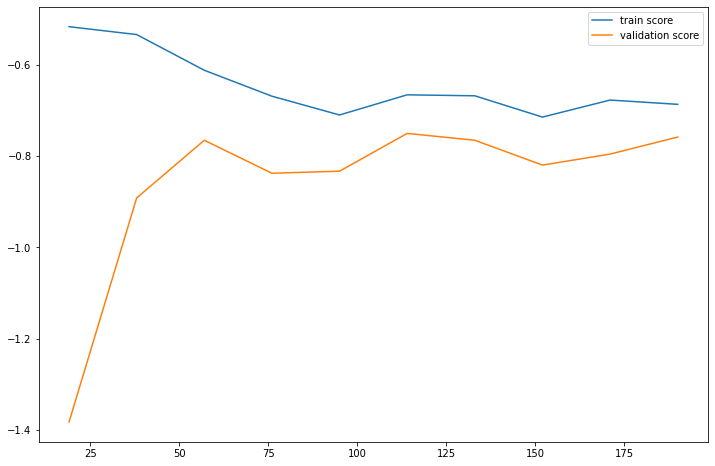

SVM:
explained variance :  0.20772029464413921
R2 : 0.14611406227662427


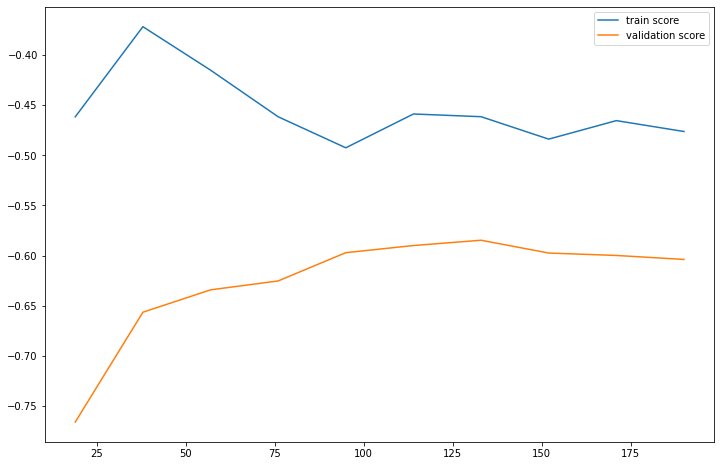

In [130]:
for name, model in dict_regression.items():
    print(name)
    evaluation(model, 'neg_mean_absolute_error')

**Comparaison des deux modèles :** On constate que les valeurs du $R^2$ et de la part de la variance expliquée sont très faibles dans le modèle reglin, en comparaison avec le modèle svr. Ceci étant dit, les courbes des jeux d'entrainement et des jeux de test dans les deux cas convergent vers la même valeur à peu de choses près. Le score étant le même pour le train set et le validation set, on constate que les modèles ne sont pas en overfitting (on apprend pas 'trop bien' sur le jeu d'entrainement. On peut le voir car plus on augmente la taille du jeu d'entrainement, plus l'erreur augmente dans les négatifs).

**Choix de la méthode de scoring** : On choisit ici une negative mean absolute error, donnée par $MAE = \dfrac{1}{n}\sum_{i=1}^n{\left|y_{\textit{pred}} - y_{\textit{test}}\right|}$. Sklearn cherche à toujours à maximiser, c'est pourquoi la métrique de scoring est négative ici, et **on cherche à se rapprocher de 0 par les négatifs pour minimiser l'erreur**. C'est une métrique pour laquelle l'importance d'une erreur est linéaire avec son amplitude. Dans notre cas, ce choix est judicieux : les prix des billets d'avions très chers correspondent très probablement à des trajets qui n'existent pas en direct en avion , car trop proches, et en conséquence, correspondent à des prix qvec correspondance. Le site sur lequel les données ont été scrappées propose des trajets et non des billets unique. Il est donc cohérent d'attribuer les erreurs aux valeurs aberrantes. Celà permet de ne pas inclure dans les valeurs aberrantes la partie chère des billets qui sont eux des trajets directs. Pour s'en convaincre, on va utiliser d'autres métriques.

***mean_squared_error :*** $MSE = \dfrac{1}{n}\sum_{i=1}^n{\left(y_{\textit{pred}} - y_{\textit{test}}\right)^2}$

Regression linéaire:
explained variance :  0.07440253050461465
R2 : 0.07232101031144789


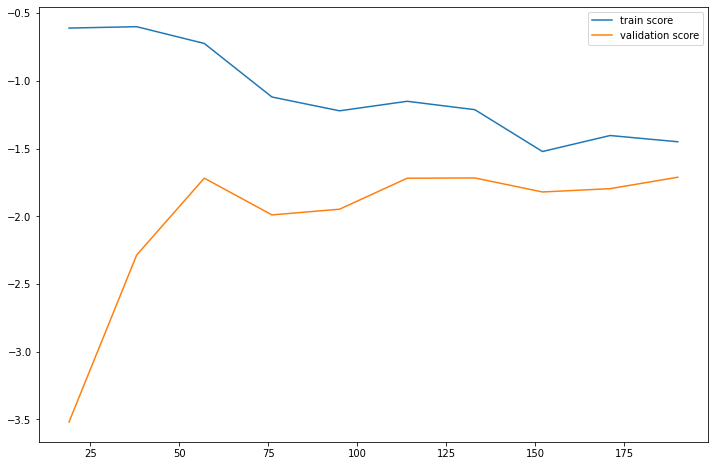

SVM:
explained variance :  0.20772029464413921
R2 : 0.14611406227662427


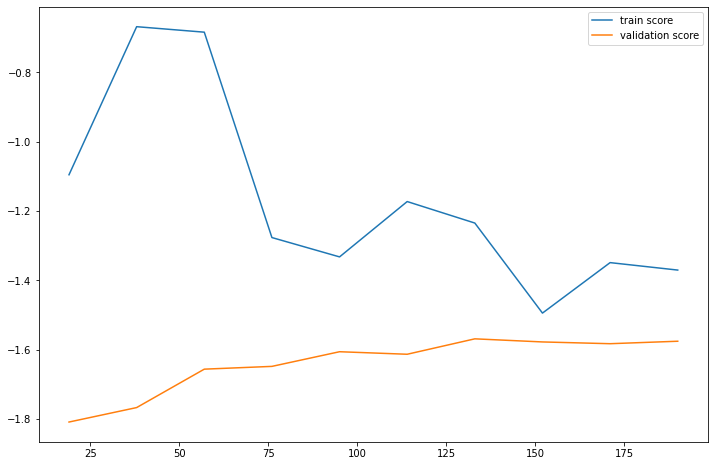

In [131]:
for name, model in dict_regression.items():
    print(name)
    evaluation(model, 'neg_mean_squared_error')

$\to$ Toujours pas d'overfitting majeur constaté. Cependant, le scoring est bien moins élevé que pour la MAE.

Regression linéaire:
explained variance :  0.07440253050461465
R2 : 0.07232101031144789


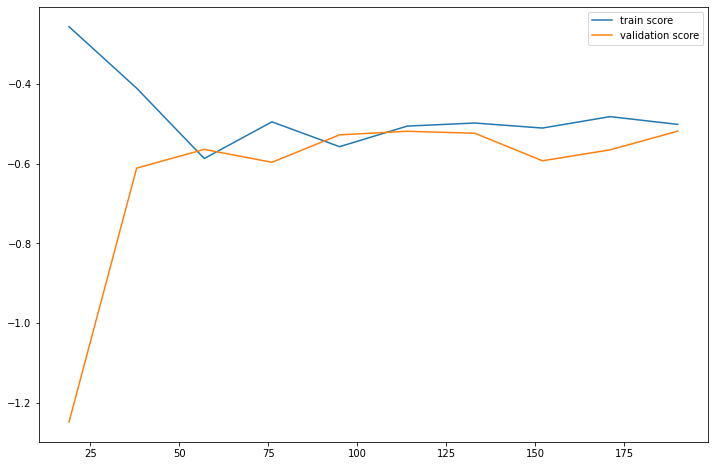

SVM:
explained variance :  0.20772029464413921
R2 : 0.14611406227662427


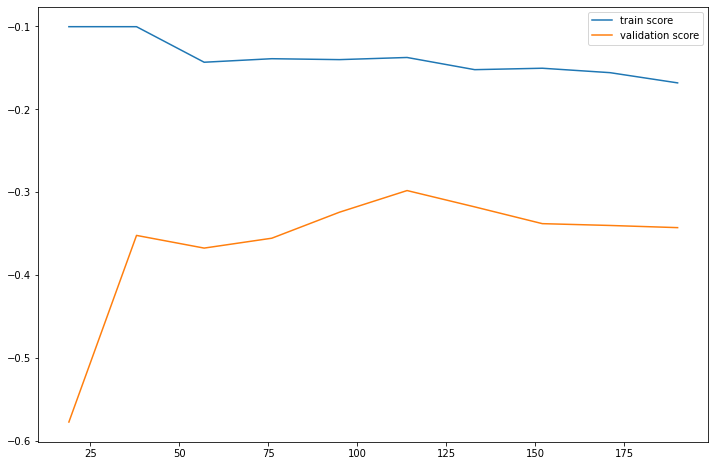

In [132]:
for name, model in dict_regression.items():
    print(name)
    evaluation(model, 'neg_median_absolute_error')

$\to$ La median absolute error est elle aussi l'une des plus efficace. Comme la MAE, elle est très peu sensible aux grandes erreurs, puisque la médiane est très peu sensible aux grandes erreur.

On va maintenant tenter d'optimiser le modèle SVR, qui eest le plus fructueux au sens du $R^2$, c'est à dire celui qui explique un plus grande partie du dataset. On va conserver les métrique MAE et median_absolute_error.

Dans la suite, on va s'interesser aux hyperparamètres du modèle.

In [133]:
#On affiche la liste des hyperparamètres disponibles dans le modèle.
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

**MAE**

In [136]:
from sklearn.model_selection import GridSearchCV

params = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
          'gamma':['scale', 'auto'],
          'C': numpy.linspace(0.1,2,20)}
grid = GridSearchCV(svr, params, cv = 4, scoring = 'neg_mean_absolute_error')
grid.fit(X_train, Y_train)
grid.best_params_

{'C': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}

In [137]:
grid.best_score_

-0.5937219591925588

**Median absolute error**

In [138]:
grid = GridSearchCV(svr, params, cv = 4, scoring = 'neg_median_absolute_error')
grid.fit(X_train, Y_train)
grid.best_params_

{'C': 0.7, 'gamma': 'scale', 'kernel': 'rbf'}

In [139]:
grid.best_score_

-0.3210660088043734

$\to$ Si la recherche de paramètre a été presque la même dans les deux cas, on constate tout de même que l'erreur médiane est plus proche de 0, donc a de meilleures performances.

**Conclusion sur cette première approche de régression :** On a une erreur qui est minimisée à 0,3. Ce n'est pas une valeur très proche de 0. Cependant, compte tenu du peu de données qu'on avait à disposition, on peut considérer que cette performance est satisfaisante. Prédire une variable aussi précise qu'un prix induit forcément de plus grandes erreurs si la base de données est petite.


Voyons maintenant le modèle de svr avec la base de donnée incluant les mois des départs et non le temps jusqu'au départ.

### **Deuxième dataset**
(Contient la variable $\textit{Mois}$)

In [163]:
dfm_bis = df_bis.copy()
dfm_bis.Prix = dfm_bis.Prix.astype('float')
#Même traitement que la première fois

In [164]:
dfm_bis

,Départ,Arrivée,Prix,Mois,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,Paris,Rennes,133.0,jan,Paris,Rennes,329.462708,193.0
1,Paris,Rennes,136.0,fév,Paris,Rennes,329.462708,193.0
2,Paris,Rennes,293.0,mar,Paris,Rennes,329.462708,193.0
3,Paris,Rennes,134.0,avr,Paris,Rennes,329.462708,193.0
4,Paris,Rennes,130.0,mai,Paris,Rennes,329.462708,193.0
...,...,...,...,...,...,...,...,...
338,Nice,Paris,150.0,août,Nice,Paris,689.267534,317.0
339,Nice,Paris,124.0,sep,Nice,Paris,689.267534,317.0
340,Nice,Paris,124.0,oct,Nice,Paris,689.267534,317.0
341,Nice,Paris,121.0,nov,Nice,Paris,689.267534,317.0


In [165]:
dfm_bis = dfm_bis.drop(['Départ', 'Arrivée'], axis=1)

Premier constat : une base un peu plus grande.

In [166]:
ohe = OneHotEncoder(sparse = False)
rob = RobustScaler()

In [167]:
# Normalisation des variables flottantes
for flo in dfm_bis.select_dtypes('float'):
    dfm_bis[flo] = rob.fit_transform(numpy.array(dfm_bis[flo]).reshape(-1,1))

In [168]:
dfm_bis

,Prix,Mois,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,-0.336634,jan,Paris,Rennes,-0.401107,-0.456790
1,-0.277228,fév,Paris,Rennes,-0.401107,-0.456790
2,2.831683,mar,Paris,Rennes,-0.401107,-0.456790
3,-0.316832,avr,Paris,Rennes,-0.401107,-0.456790
4,-0.396040,mai,Paris,Rennes,-0.401107,-0.456790
...,...,...,...,...,...,...
338,0.000000,août,Nice,Paris,0.960195,1.074074
339,-0.514851,sep,Nice,Paris,0.960195,1.074074
340,-0.514851,oct,Nice,Paris,0.960195,1.074074
341,-0.574257,nov,Nice,Paris,0.960195,1.074074


In [169]:
#Encodage des valeurs catégorielles


arr = ohe.fit_transform(numpy.array(dfm_bis['Gare de départ']).reshape(-1,1))
names = ohe.categories_
names = [x + '_d'for x in names[0]] #on identifie les variables des villes avec un _départ pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = dfm_bis.drop('Gare de départ', axis = 1)
dfm_bis = pandas.concat([temp, arr2], axis = 1)


arr = ohe.fit_transform(numpy.array(dfm_bis['Gare d arrivée']).reshape(-1,1))
names = ohe.categories_
names = [x + '_a'for x in names[0]]  #on identifie les variables des villes avec un _arrivée pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = dfm_bis.drop('Gare d arrivée', axis = 1)
dfm_bis = pandas.concat([temp, arr2], axis = 1)

arr = ohe.fit_transform(numpy.array(dfm_bis['Mois']).reshape(-1,1))
names = ohe.categories_
names = [x for x in names[0]]
arr2 = pandas.DataFrame(arr, columns = names)
temp = dfm_bis.drop('Mois', axis = 1)
dfm_bis = pandas.concat([temp, arr2], axis = 1)


In [170]:
dfm_bis.columns

Index(['Prix', 'Distance du trajet', 'Prix moyen', 'Bordeaux_d', 'Lyon_d',
       'Marseille_d', 'Nantes_d', 'Nice_d', 'Paris_d', 'Lille_a', 'Lyon_a',
       'Marseille_a', 'Montpellier_a', 'Nantes_a', 'Nice_a', 'Paris_a',
       'Rennes_a', 'Toulouse_a', 'août', 'avr', 'déc', 'fév', 'jan', 'juil',
       'juin', 'mai', 'mar', 'nov', 'oct', 'sep'],
      dtype='object')

In [171]:
#On peut vérifier que l'encodage catégoriel a bien été fait
df_bis['Gare d arrivée'].unique(), df_bis['Gare de départ'].unique(), df_bis.Mois.unique()

(array(['Rennes', 'Montpellier', 'Toulouse', 'Lille', 'Nantes',
        'Marseille', 'Nice', 'Lyon', 'Paris'], dtype=object),
 array(['Paris', 'Nantes', 'Marseille', 'Lyon', 'Bordeaux', 'Nice'],
       dtype=object),
 array(['jan', 'fév', 'mar', 'avr', 'mai', 'juin', 'juil', 'août', 'sep',
        'oct', 'nov', 'déc'], dtype=object))

In [172]:
#Séparation jeu d'entrainement, jeu de test

train_df2, test_df2= train_test_split(dfm_bis, test_size = 0.2, random_state = 0)

In [173]:
X_train_bis = train_df2.drop('Prix', axis = 1) #ce sur quoi le modèle apprend
Y_train_bis = train_df2['Prix'] #L'objectif, la variable à prédire

X_test_bis = test_df2.drop('Prix', axis = 1)
Y_test_bis = test_df2['Prix']

In [180]:
def evaluation_bis(model, scor):
    model.fit(X_train_bis, Y_train_bis)
    y_pred_bis = model.predict(X_test_bis)
    
    print('explained variance : ', explained_variance_score(Y_test_bis, y_pred_bis))
    print('R2 :',r2_score(Y_test_bis, y_pred_bis))
    
    N, train_score, val_score = learning_curve(model, X_train_bis, Y_train_bis, cv = 4, scoring = scor, train_sizes = numpy.linspace(0.1,1,10))
    plt.figure(figsize = (12,8))
    plt.plot(N, train_score.mean(axis = 1), label = 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.legend()
    plt.show()

In [181]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
svr = SVR()

explained variance :  0.5890185767955667
R2 : 0.5829940038927626


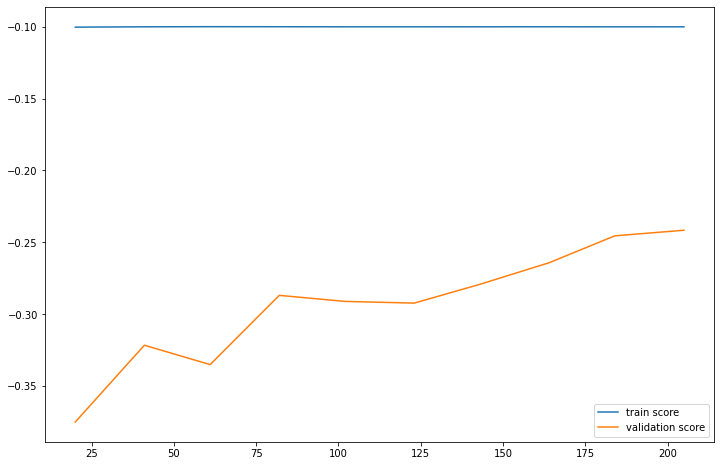

In [182]:
evaluation_bis(svr, 'neg_median_absolute_error')

$\to$ Comme on a une courbe d'entrainement presque constante, il est raisonnable de penser que le modèle est en overfitting, c'est-à-dire qu'il prévoit trop bien les données sur le jeu d'entrainement.

explained variance :  0.35666211541676773
R2 : 0.3360831503940125


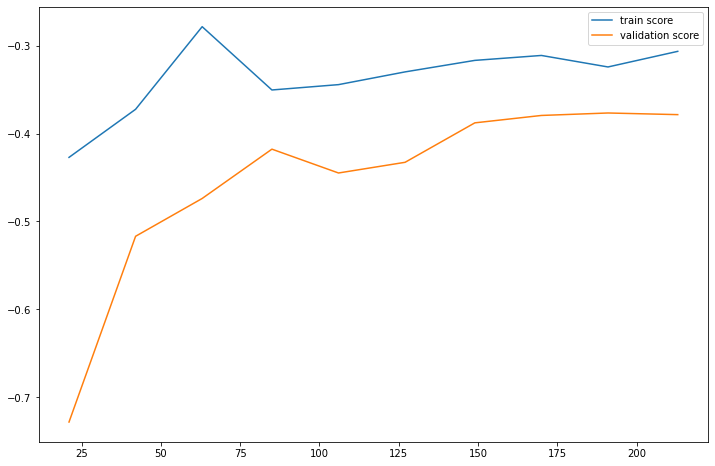

In [ ]:
evaluation_bis(knn, 'neg_median_absolute_error')

**Justification du choix du modèle :** On peut imaginer qu'en prenant en compte les mois dans les données, on se rapproche de la notion de voisins : on aura des prix potentiellement similaires sur les même mois. Là encore, on ne constate pas d'overfitting. Le score est similaire à ce que l'on avait pu observer sur les autres modèles. On peut encore fairre tourner un GridSearchCV pour avoir un aperçu du meilleur jeu de paramètres pour ce modèle.

In [184]:
pars = {'n_neighbors' : numpy.arange(1,11),
        'weights' : ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': numpy.arange(20,41),
        'metric': ['euclidean', 'manhattan']}


grid = GridSearchCV(knn, pars, cv = 4, scoring = 'neg_median_absolute_error')
grid.fit(X_train_bis, Y_train_bis)
grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'metric': 'manhattan',
 'n_neighbors': 10,
 'weights': 'distance'}

In [185]:
grid.best_score_

-0.31539334108498673

$\to$ On voit que l'erreur peine à descendre en dessous de 30%, ce qui peut signifier que la taille du dataset est un vrai frein à l'amélioration du score. 

### **Dernier essai : fusion des deux datasets**
Cette partie a un but plus expérimental : voir si l'on peut obtenir de bons résultats en sacrifiant le nombre de lignes du dataset au profit d'une description plus préciser (combiner TEMPS et MOIS sur les trajets)

In [191]:
bdd_fin = pandas.merge(bdd_corr_11, bdd_corr_21, left_on =[bdd_corr_11['Gare de départ'],bdd_corr_11['Gare d arrivée'], bdd_corr_11['Prix']],
                   right_on = [bdd_corr_21['Gare de départ'],bdd_corr_21['Gare d arrivée'], bdd_corr_21['Prix']], how ='inner')

In [192]:
bdd_fin.head()

,key_0,key_1,key_2,Prix_x,Temps,Gare de départ_x,Gare d arrivée_x,Distance du trajet_x,Prix moyen_x,Départ,Arrivée,Prix_y,Mois,Gare de départ_y,Gare d arrivée_y,Distance du trajet_y,Prix moyen_y
0,Marseille,Rennes,149,149,8,Marseille,Rennes,773.008188,322.0,Marseille,Rennes,149,juil,Marseille,Rennes,773.008188,322.0
1,Marseille,Rennes,149,149,9,Marseille,Rennes,773.008188,322.0,Marseille,Rennes,149,juil,Marseille,Rennes,773.008188,322.0
2,Paris,Toulouse,145,145,4,Paris,Toulouse,589.331100,251.0,Paris,Toulouse,145,août,Paris,Toulouse,589.331100,251.0
3,Paris,Toulouse,116,116,7,Paris,Toulouse,589.331100,251.0,Paris,Toulouse,116,fév,Paris,Toulouse,589.331100,251.0
4,Marseille,Toulouse,137,137,2,Marseille,Toulouse,325.021653,169.0,Marseille,Toulouse,137,jan,Marseille,Toulouse,325.021653,169.0


In [194]:
bdd_fin = bdd_fin.drop(['key_0', 'key_1', 'key_2', 'Prix_x','Prix moyen_x', 'Gare de départ_x', 'Gare d arrivée_x', 'Départ', 'Arrivée', 'Distance du trajet_x'], axis = 1)
bdd_fin.columns = ['Temps', 'Prix','Mois', 'Gare de départ', 'Gare d arrivée', 'Distance du trajet', 'Prix moyen']

In [195]:
bdd_fin.head()

,Temps,Prix,Mois,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,8,149,juil,Marseille,Rennes,773.008188,322.0
1,9,149,juil,Marseille,Rennes,773.008188,322.0
2,4,145,août,Paris,Toulouse,589.331100,251.0
3,7,116,fév,Paris,Toulouse,589.331100,251.0
4,2,137,jan,Marseille,Toulouse,325.021653,169.0


$\to$ On passe dans le même processus que pour les autres datasets

In [196]:
bdd_fin.Prix = bdd_fin.Prix.astype('float')
bdd_fin.Temps = bdd_fin.Temps.astype('float')

In [197]:
# Normalisation des variables flottantes
for flo in bdd_fin.select_dtypes('float'):
    bdd_fin[flo] = rob.fit_transform(numpy.array(bdd_fin[flo]).reshape(-1,1))

In [198]:
bdd_fin.head()

,Temps,Prix,Mois,Gare de départ,Gare d arrivée,Distance du trajet,Prix moyen
0,0.500000,0.074534,juil,Marseille,Rennes,0.812001,1.295775
1,0.666667,0.074534,juil,Marseille,Rennes,0.812001,1.295775
2,-0.166667,-0.024845,août,Paris,Toulouse,0.273334,0.295775
3,0.333333,-0.745342,fév,Paris,Toulouse,0.273334,0.295775
4,-0.500000,-0.223602,jan,Marseille,Toulouse,-0.501803,-0.859155


In [199]:
#Encodage des valeurs catégorielles


arr = ohe.fit_transform(numpy.array(bdd_fin['Gare de départ']).reshape(-1,1))
names = ohe.categories_
names = [x + '_d'for x in names[0]] #on identifie les variables des villes avec un _départ pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = bdd_fin.drop('Gare de départ', axis = 1)
bdd_fin = pandas.concat([temp, arr2], axis = 1)


arr = ohe.fit_transform(numpy.array(bdd_fin['Gare d arrivée']).reshape(-1,1))
names = ohe.categories_
names = [x + '_a'for x in names[0]]  #on identifie les variables des villes avec un _arrivée pour les départs
arr2 = pandas.DataFrame(arr, columns = names)
temp = bdd_fin.drop('Gare d arrivée', axis = 1)
bdd_fin = pandas.concat([temp, arr2], axis = 1)

arr = ohe.fit_transform(numpy.array(bdd_fin['Mois']).reshape(-1,1))
names = ohe.categories_
names = [x for x in names[0]]
arr2 = pandas.DataFrame(arr, columns = names)
temp = bdd_fin.drop('Mois', axis = 1)
bdd_fin = pandas.concat([temp, arr2], axis = 1)


In [200]:
bdd_fin.head()

,Temps,Prix,Distance du trajet,Prix moyen,Bordeaux_d,Lyon_d,Marseille_d,Nantes_d,Nice_d,Paris_d,Lille_a,Lyon_a,Marseille_a,Nantes_a,Nice_a,Paris_a,Rennes_a,Toulouse_a,août,avr,déc,fév,jan,juil,juin,mai,mar,nov,oct,sep
0,0.500000,0.074534,0.812001,1.295775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.666667,0.074534,0.812001,1.295775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.166667,-0.024845,0.273334,0.295775,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,-0.745342,0.273334,0.295775,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.500000,-0.223602,-0.501803,-0.859155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
train_df3, test_df3= train_test_split(bdd_fin, test_size = 0.2, random_state = 0)

In [202]:
X_train_fin = train_df3.drop('Prix', axis = 1) #ce sur quoi le modèle apprend
Y_train_fin = train_df3['Prix'] #L'objectif, la variable à prédire

X_test_fin = test_df3.drop('Prix', axis = 1)
Y_test_fin = test_df3['Prix']

In [203]:
def evaluation_fin(model, scor):
    model.fit(X_train_fin, Y_train_fin)
    y_pred_fin = model.predict(X_test_fin)
    
    print('explained variance : ', explained_variance_score(Y_test_fin, y_pred_fin))
    print('R2 :',r2_score(Y_test_fin, y_pred_fin))
    
    N, train_score, val_score = learning_curve(model, X_train_fin, Y_train_fin, cv = 4, scoring = scor, train_sizes = numpy.linspace(0.1,1,10))
    plt.figure(figsize = (12,8))
    plt.plot(N, train_score.mean(axis = 1), label = 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.legend()
    plt.show()

explained variance :  -1.481511254019292
R2 : -1.492363344051446


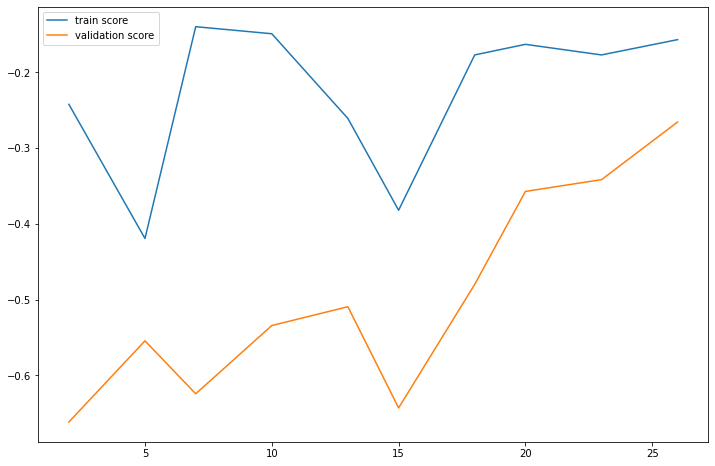

In [204]:
knn = KNeighborsRegressor(n_neighbors = 2)
evaluation_fin(knn, 'neg_median_absolute_error')

In [205]:
pars = {'n_neighbors' : numpy.arange(1,3),
        'weights' : ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': numpy.arange(20,41),
        'metric': ['euclidean', 'manhattan']}


grid = GridSearchCV(knn, pars, cv = 4, scoring = 'neg_median_absolute_error')
grid.fit(X_train_fin, Y_train_fin)
grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'metric': 'manhattan',
 'n_neighbors': 2,
 'weights': 'distance'}

In [206]:
grid.best_score_

-0.2258469460676798

$\to$ On a réussi à diminuer l'erreur d'environ 30% de l'erreur obtenue avec les autres datasets. Cependant, on a un $R^2$ beaucoup plus faible, ce qui signifie qu'on a moins expliqué les données. **Fusionner les tables n'est donc pas forcément une meilleure approche que nos études séparées au préalable**